FAO_CommodityBalances_LivestockFish

# Pre-Load

## Libraries and Settings

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image

import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)
DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print('')

DATA_FAO = os.path.join(DATA_BASE, 'FAO')
FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'
SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
# print(f'FAO data director: {DATA_FAO}')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
print(f'Suffix of raw FAO data file name: {SUFFIX}')
# print('')

DATA_NBS = os.path.join(DATA_BASE, 'NBS')
NBS_meta = os.path.join(DATA_NBS, 'metadata')
# print(f'NBS data director: {DATA_NBS}')
# print(f'NBS metadata director: {NBS_meta}')
# print('')

DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green2 = '#00c853'
GF_green1 = '#b9f6ca'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

In [4]:
domain = 'FAO_CommodityBalances_LivestockFish'

# path_img = f'{LOCAL_ROOT}/results/{domain}/img/'
# path_map = f'{LOCAL_ROOT}/results/{domain}/map/'

# for i in os.listdir(path_img):
#     path_file = os.path.join(path_img,i)  
#     if os.path.isfile(path_file):
#           os.remove(path_file)
            
# for i in os.listdir(path_map):
#     path_file = os.path.join(path_map,i)
#     if os.path.isfile(path_file) and path_file.endswith(".html"):
#           os.remove(path_file)

## Variables

In [5]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents

## Meta Data

In [6]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [7]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

## Read Data Frame

In [8]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding=encoding)
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

In [9]:
# 给 Domain 赋值，查看数据基础信息
with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

D = domain[4:]

In [10]:
""" Check update information if you've run update cell before, and if the domain has been updated , uncomment this cell. """
with ZipFile(FAO_BULK_zip, 'r') as zf1:
    zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)      

In [11]:
# Show you raw data
DATA = rdDF(D)
print('data shape: ', DATA.shape)

{'DatasetCode': 'BL',
 'DatasetName': 'Food Balance: Commodity Balances - Livestock and Fish Primary Equivalent',
 'Topic': 'Most crop and livestock products, including processed products, under agricultural activity.',
 'DatasetDescription': 'Food supply data is some of the most important data in FAOSTAT. In fact, this data is for the basis for estimation of global and national undernourishment assessment, when it is combined with parameters and other data sets. This data has been the foundation of food balance sheets ever since they were first constructed. The data is accessed by both business and governments for economic analysis and policy setting, as well as being used by the academic community.',
 'MedaData': ['Mr. Salar Tayyib',
  'faostat@fao.org',
  '2018-01-17',
  'zip',
  'csv',
  '16605KB',
  '2868088'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/CommodityBalances_LivestockFish_E_All_Data_(Normalized).zip'}

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,2731,Bovine Meat,5510,Production,1961,1961,tonnes,43000.0,S
1,2,Afghanistan,2731,Bovine Meat,5510,Production,1962,1962,tonnes,45800.0,S
2,2,Afghanistan,2731,Bovine Meat,5510,Production,1963,1963,tonnes,47250.0,S
3,2,Afghanistan,2731,Bovine Meat,5510,Production,1964,1964,tonnes,48000.0,S
4,2,Afghanistan,2731,Bovine Meat,5510,Production,1965,1965,tonnes,48700.0,S


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2459786,5817,Net Food Importing Developing Countries,2945,Offals,5153,Other uses,2009,2009,tonnes,43075.0,A
2459787,5817,Net Food Importing Developing Countries,2945,Offals,5153,Other uses,2010,2010,tonnes,25138.0,A
2459788,5817,Net Food Importing Developing Countries,2945,Offals,5153,Other uses,2011,2011,tonnes,27344.0,A
2459789,5817,Net Food Importing Developing Countries,2945,Offals,5153,Other uses,2012,2012,tonnes,26644.0,A
2459790,5817,Net Food Importing Developing Countries,2945,Offals,5153,Other uses,2013,2013,tonnes,35772.0,A


data shape:  (2459791, 11)


## Show Countries and Groups

In [12]:
# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
# print('Countries in FAO data of this domain: ')
# display(Countries_FAO)

# Countries in geojson
with open(f'{FAO_meta}/geojson/world_countries.json') as json_file:
    json_data = json.load(json_file)
Countries_json = []
for feature in json_data['features']:
    Countries_json.append(feature['properties']['name'])
# print('Countries in geojson: ')
# display(Countries_json)

# Countries in FAO but not in geojson
Countries_no_json = [c for c in Countries_FAO if c not in Countries_json]
print('Countries in FAO but not in geojson: ')
display(Countries_no_json)

# Countries in geojson but not in FAO
Countries_no_FAO = [c for c in Countries_json if c not in Countries_FAO]
print('Countries in geojson but not in FAO: ')
display(Countries_no_FAO)

# Countries in both FAO and geojson
Countries = [c for c in Countries_json if c in Countries_FAO]
# print('Countries in geojson but not in FAO: ')
# display(Countries)

Countries in FAO but not in geojson: 


['Antigua and Barbuda',
 'Barbados',
 'Belgium-Luxembourg',
 'Bermuda',
 'Cabo Verde',
 "C魌e d'Ivoire",
 'Czechoslovakia',
 'Dominica',
 'Ethiopia PDR',
 'French Polynesia',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Malta',
 'Mauritius',
 'Netherlands Antilles (former)',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Serbia and Montenegro',
 'Sudan (former)',
 'USSR',
 'Yugoslav SFR']

Countries in geojson but not in FAO: 


['Antarctica',
 'French Southern and Antarctic Lands',
 'Burundi',
 'Bhutan',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Northern Cyprus',
 'Eritrea',
 'Falkland Islands (Malvinas)',
 'Equatorial Guinea',
 'Greenland',
 'Kosovo',
 'Libya',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Western Sahara',
 'South Sudan',
 'Somaliland',
 'Somalia',
 'Syrian Arab Republic',
 'West Bank']

In [13]:
"""adjust FAO countries name"""
# rename because of decoding error
DATA.loc[DATA['Area']=="C魌e d'Ivoire", 'Area'] = "Côte d'Ivoire"

# Countries too small to consider for now
Countries_too_small = [
    'Antigua and Barbuda',  # 安提瓜和巴布达
    'Barbados',             # 巴巴多斯
    'Bermuda',              # 百慕大
    'Cabo Verde',           # 弗德角
    'Dominica',             # 多米尼克, 非多米尼加共和国
    'French Polynesia',     # 法属玻璃尼亚  a part of 'French Southern and Antarctic Lands' of geojson
    'Grenada',              # 格林纳达
    'Kiribati',             # 基里巴斯
    'Maldives',             # 马尔代夫
    'Malta',                # 马耳他
    'Mauritius',            # 毛里求斯
    'Saint Kitts and Nevis',  # 圣基茨和尼维斯
    'Saint Lucia',            # 圣卢西亚
    'Saint Vincent and the Grenadines', # 圣文森特和格林纳丁斯
    'Samoa',                  # 萨摩亚
    'Sao Tome and Principe',  # 圣多美和普林西比
]
DATA = DATA[~DATA['Area'].isin(Countries_too_small)]

# Countries not exists now
Countries_not_now = [
    # 与前苏联解体相关
    'Czechoslovakia',        # dissolved 1992, 捷克斯洛伐克
    'Ethiopia PDR',          # 1987~1991, 埃塞俄比亚人民民主共和国
    'USSR',                  # dissolved 1991
    'Yugoslav SFR',          # 1945~1992, 南斯拉夫社会主义联邦共和国
    'Serbia and Montenegro',         # 1992~2006, 塞尔维亚和黑山国家联盟
    # 
    'Netherlands Antilles (former)', # dissolved 2010, islands, too small
    # 苏丹
    'Sudan (former)',                # dissolved 2011
]
# disslved see map for old

"""adjust geojson"""
# China SARs
China_SARs = [                           # added
    'China, Hong Kong SAR', # add new polygon
    'China, Macao SAR',     # add new polygon
]

# Two Countries can say one or can say independently  # Use 'Belgium' and 'Luxembourg'
Belgium_Luxembourg = [
    'Belgium',
    'Luxembourg',
]
DATA = DATA[~DATA['Area'].isin(['Belgium-Luxembourg'])]

# Sudan (former)                          ! not considered now
Sudan_former = [
    'Sudan',
    'South Sudan',
]

# Add a map before 1992, where:
# following countries in 'USSR'           # added
USSR = [
    "Russian Federation"
    "Kazakhstan",          # 哈萨克斯坦
    "Estonia",             # 爱沙尼亚
    "Ukraine",             # 乌克兰
    "Belarus",             # 白俄罗斯
    "Uzbekistan",          # 乌兹别克斯坦
    "Georgia",             # 格鲁吉亚
    "Azerbaijan",          # 阿塞拜疆
    "Lithuania",           # 立陶宛
    "Republic of Moldova", # 摩尔多瓦
    "Latvia",              # 拉脱维亚
    "Kyrgyzstan",          # 吉尔吉斯斯坦
    "Tajikistan",          # 塔吉克斯坦
    "Armenia",             # 阿美妮娅
    "Turkmenistan",        # 土库曼斯坦
]

# following countries in 'Czechoslovakia'
Czechoslovakia = [
    'Czechia',
    'Slovakia',
]

# following countries in 'Yugoslav SFR'  ! not considered now
Yugoslav_SFR = [
    'The former Yugoslav Republic of Macedonia', # 1992~, 继任前南斯拉夫的北马其顿，rename in geojson from 'North Macedonia'
    'Serbia',      # 2006~
    'Montenegro',  # 2006~
]

# Add a map 1992~2006, where:            ! not added for not considered now
Serbia_Montenegro = [
    'Serbia',     # 2006~
    'Montenegro', # 2006~
]


# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
print('Countries in FAO data of this domain: ')
display(Countries_FAO)

# Groups in FAO
Groups_FAO = DATA[DATA['Area Code']>=5000]['Area'].unique().tolist()
print('Groups in FAO: ')
display(Groups_FAO)

Countries in FAO data of this domain: 


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 "Democratic People's Republic of Korea",
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Ethiopia PDR',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 

Groups in FAO: 


['World',
 'Africa',
 'Eastern Africa',
 'Middle Africa',
 'Northern Africa',
 'Southern Africa',
 'Western Africa',
 'Americas',
 'Northern America',
 'Central America',
 'Caribbean',
 'South America',
 'Asia',
 'Central Asia',
 'Eastern Asia',
 'Southern Asia',
 'South-Eastern Asia',
 'Western Asia',
 'Europe',
 'Eastern Europe',
 'Northern Europe',
 'Southern Europe',
 'Western Europe',
 'Oceania',
 'Australia & New Zealand',
 'Melanesia',
 'Micronesia',
 'Polynesia',
 'European Union',
 'Least Developed Countries',
 'Land Locked Developing Countries',
 'Small Island Developing States',
 'Low Income Food Deficit Countries',
 'Net Food Importing Developing Countries']

In [14]:
# 加载国家列表
LIST_countries = Countries_FAO
print(f'There are {len(LIST_countries)} countries')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = Groups_FAO
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# China
China = ['China, mainland']+China_SARs+['China, Taiwan Province of']

# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# BRICS
LIST_countries_BRICS = ['Brazil', 'India', 'Russian Federation', 'South Africa'] + China

# EU
LIST_countries_EU = []
with open(FAO_meta+'/list_countries_EU.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_EU.append(line)

# G20
LIST_countries_G20 = []
with open(FAO_meta+'/list_countries_G20.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_G20.append(line)
LIST_countries_G20 = list(set(LIST_countries_G20 + LIST_countries_EU + China))

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 165 countries
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


## Show Years Range

In [15]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1961 ~ 2013
You choose years range: 1961 ~ 2013


## Show Element and Items

In [16]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (2283072, 7)
data shape after drop Non. and Dup.:  (2132504, 7)
Groupe data by Elements and Items: 


Area Code  Area  Year  \
Element                       Item                                             
Domestic supply quantity      Animal fats                   9453  9453  9453   
                              Aquatic Animals, Others       7732  7732  7732   
                              Aquatic Plants                8871  8871  8871   
                              Aquatic Products, Other       9091  9091  9091   
                              Bovine Meat                   9453  9453  9453   
                              Butter, Ghee                  9453  9453  9453   
                              Cephalopods                   9281  9281  9281   
                              Cheese                        9400  9400  9400   
                              Cream                         8691  8691  8691   
                              Crustaceans                   9398  9398  9398   
                              Demersal Fish                 9400  9400  9400   
                              Eggs                          9547  9547  9547   
                              Fats, Animals, Raw            9453  9453  9453   
                              Fish Meal                     9238  9238  9238   
                              Fish, Body Oil                8951  8951  8951   
                              Fish, Liver Oil               8208  8208  8208   
                              Fish, Seafood                 9453  9453  9453   
                              Freshwater Fish               9453  9453  9453   
                              Hides and skins               9400  9400  9400   
                              Honey                         9347  9347  9347   
                              Marine Fish, Other            9347  9347  9347   
                              Meat                          9453  9453  9453   
                              Meat Meal                     8564  8564  8564   
                              Meat, Aquatic Mammals          424   424   424   
                              Meat, Other                   9453  9453  9453   
                              Milk - Excluding Butter       9624  9624  9624   
                              Milk, Skimmed                 9400  9400  9400   
                              Milk, Whole                   9453  9453  9453   
                              Molluscs, Other               9366  9366  9366   
                              Mutton & Goat Meat            9453  9453  9453   
                              Offals                        9453  9453  9453   
                              Offals, Edible                9453  9453  9453   
                              Pelagic Fish                  9400  9400  9400   
                              Pigmeat                       9347  9347  9347   
                              Poultry Meat                  9453  9453  9453   
                              Silk                          6784  6784  6784   
                              Whey                          8661  8661  8661   
                              Wool (Clean Eq.)              7760  7760  7760   
Export Quantity               Animal fats                   8954  8954  8954   
                              Aquatic Animals, Others       5448  5448  5448   
                              Aquatic Plants                6450  6450  6450   
                              Aquatic Products, Other       7086  7086  7086   
                              Bovine Meat                   8879  8879  8879   
                              Butter, Ghee                  8361  8361  8361   
                              Cephalopods                   7834  7834  7834   
                              Cheese                        8116  8116  8116   
                              Cream                         6573  6573  6573   
                              Crustaceans                   8802  8802  8802   
                              Demersal Fish            

# Data Visualization

## Parameter Settings

### Area Selection

In [17]:
# 给 Area 赋值
A = 'China, mainland'

data = DATA.copy()

df_area = data[data['Area']==A]

# display(data.groupby(['Element','Item']).count())
display('Elements:', data.Element.unique())
display('Items:', data.Item.unique())

'Elements:'

array(['Production', 'Import Quantity', 'Domestic supply quantity',
       'Food supply quantity (tonnes)', 'Seed', 'Losses', 'Other uses',
       'Stock Variation', 'Export Quantity', 'Feed', 'Processing'],
      dtype=object)

'Items:'

array(['Bovine Meat', 'Butter, Ghee', 'Cheese', 'Cream', 'Eggs',
       'Fats, Animals, Raw', 'Freshwater Fish', 'Hides and skins',
       'Honey', 'Meat, Other', 'Milk - Excluding Butter', 'Milk, Skimmed',
       'Milk, Whole', 'Mutton & Goat Meat', 'Offals, Edible',
       'Poultry Meat', 'Silk', 'Whey', 'Wool (Clean Eq.)', 'Animal fats',
       'Fish, Seafood', 'Meat', 'Offals', 'Aquatic Animals, Others',
       'Aquatic Plants', 'Cephalopods', 'Crustaceans', 'Demersal Fish',
       'Fish Meal', 'Fish, Body Oil', 'Fish, Liver Oil',
       'Marine Fish, Other', 'Meat Meal', 'Molluscs, Other',
       'Pelagic Fish', 'Pigmeat', 'Aquatic Products, Other',
       'Meat, Aquatic Mammals'], dtype=object)

In [18]:
def mkPV_forArea_ItemYear(area, element):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Element']==element)]
    df = pd.pivot_table(df,index=['Item'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot  

def mkPV_forArea_ElementYear(area, item):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Item']==item)]
    df = pd.pivot_table(df,index=['Element'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot

In [19]:
# 用于单项测试，可展示某item 相对其他 item 在同一个 area 内的 排名变化，筛选主要的品类，空值可跳过
E = ''

I = ''

pivot=pd.DataFrame()
if E != '': pivot = mkPV_forArea_ItemYear(A, E)
if I != '': pivot = mkPV_forArea_ElementYear(A, I)
if pivot.shape==(0,0):pass
else:
    pivot.sort_values(Years[-1], axis=0, ascending = False, inplace = True)

    rankings={}
    for i in pivot.index.values:
        ranks=np.array([])
        for y in pivot.columns:
            pivot.sort_values(y, axis=0, ascending = False, inplace = True)
            rank = pivot.index.tolist().index(i)
            ranks = np.append(ranks,rank)
        rankings[i]=ranks

    fig = plt.figure(figsize = (16,8))
    plt.title('Rankings of All Items')
    n=0
    lines = LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs
    colors = CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs
    
    for i in pivot.index.values:
        plt.plot(pivot.columns, rankings[i],color=colors[n], linestyle=lines[n])
        n+=1
    plt.legend(labels=pivot.index.values,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
    ax = plt.gca().invert_yaxis()

### Explorded Classification of Items

#### CommodityBalances_LivestockFish

    'Animal Products':['Meat','Fish, Seafood','Milk - Excluding Butter','Eggs','Offals','Animal fats'],
    'Meat': ['Poultry Meat', 'Pigmeat','Bovine Meat','Mutton & Goat Meat','Meat, Other'],
    'Fish, Seafood':['Freshwater Fish','Molluscs, Other', 'Crustaceans','Cephalopods','Demersal Fish','Pelagic Fish','Marine Fish, Other'],
    'Milk - Excluding Butter':[],
    'Eggs':[],
    'Offals':[],
    'Animal fats':[],

In [20]:
# 给 Elements 赋值
E = 'Production'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

data = df_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(Is))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

Area Code  Area  Year  Unit  Value
Element    Item                                                       
Production Bovine Meat                     53    53    53    53     53
           Eggs                            53    53    53    53     53
           Fish, Seafood                   53    53    53    53     53
           Meat                            53    53    53    53     53
           Milk - Excluding Butter         53    53    53    53     53
           Mutton & Goat Meat              53    53    53    53     53
           Pigmeat                         53    53    53    53     53
           Poultry Meat                    53    53    53    53     53

,Area Code,Area,Element,Item,Year,Value
Unit,,,,,,
tonnes,424,424,424,424,424,424


['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [21]:
def getAllItems(
    element,
    items_groups=[],
):
#     如果不设置items_groups，那么 items 仅包含 Is 的末梢，即值为空的键
    if items_groups==[]: items = ITEMs.copy()     
#     否则，items会包含 Is 中键为 items_groups 中的 item，以及所有的末梢，最后取其的 set 去掉重复元素
    else:
        items = ITEMs.copy()
        for g in items_groups:
            for i in CDTs[element][g]:
                items.append(i)
        items = list(set(items))
    return items

In [22]:
def getAllItemsInArea(
    area,
    element,
    items_groups=[],
):
    items = getAllItems(element=element, items_groups=items_groups)
    
    pivot = mkPV_forArea_ItemYear(area=area,element=element).copy()
    
    rankings = {}
    for i in items:
        if i in pivot.index:
            ranks=np.array([])
            for y in Years:
                pivot.sort_values(y, axis=0, ascending=False, inplace=True)
                rank = pivot.index.tolist().index(i)
                ranks = np.append(ranks,rank+1)
            rankings[i]=ranks
    
    df_rank = pd.DataFrame(rankings)
    df_rank.index=Years

#     # uncommets to show line plot
#     fig = plt.figure(figsize = (16,8))
#     plt.title('Rankings of Main Items in {}'.format(area))
    
#     n=0
#     lines = LSs+LSs
#     colors = CLs+CLs
#     for i in df_rank.columns.values:
#         plt.plot(Years, rankings[i], color=colors[n], linestyle=lines[n])
#         n+=1
#     plt.legend(labels=df_rank.columns,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
#     ax = plt.gca().invert_yaxis()
    
    return list(df_rank.columns)

In [23]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Animal Products', 'Meat']

ITEMs_all = getAllItemsInArea(A,E,items_groups=IsGroup)
print(ITEMs_all)

['Poultry Meat', 'Pigmeat', 'Offals', 'Meat', 'Eggs', 'Animal fats', 'Milk - Excluding Butter', 'Bovine Meat', 'Meat, Other', 'Fish, Seafood', 'Mutton & Goat Meat']


### Create Pivots for Items

In [24]:
def mkPVs_forItem_AreaYear(
    element,
    items_groups=[],
):
    items = getAllItems(element=element, items_groups=items_groups)
    
    df = DATA.copy()
    
    dfs = {}
    for i in items:
        dfs[i] = df[(df['Element']==element) & (df['Item']==i)][['Area','Year','Value']]

    pivots = {}
    for i in items:
        df = pd.pivot_table(dfs[i],index=['Area'],columns=['Year'],values=['Value'])
        df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
        df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
        if df.shape != (0, 0):
            pivots[i] = df
    return pivots

In [25]:
PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

'Production'

'Poultry Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,5600.0,6000.0,6160.0,6400.0,6800.0,7200.0,7600.0,8000.0,9600.0,9600.0,9600.0,9600.0,10000.0,10000.0,10400.0,10400.0,10800.0,11200.0,12000.0,1.2000e+04,1.2400e+04,1.2400e+04,1.2560e+04,1.2800e+04,1.2960e+04,1.3120e+04,1.2960e+04,1.2800e+04,1.2560e+04,1.2400e+04,1.2160e+04,1.2000e+04,1.1840e+04,1.1600e+04,1.2320e+04,1.3040e+04,1.4000e+04,1.5040e+04,1.4000e+04,1.3200e+04,1.3120e+04,2.4000e+04,2.8400e+04,3.0800e+04,3.2320e+04,2.4400e+04,1.7600e+04,2.0800e+04,2.0000e+04,2.8000e+04,2.5600e+04,2.4800e+04,2.6400e+04
Africa,346035.0,361882.0,376062.0,398915.0,418092.0,446635.0,475392.0,501151.0,543414.0,573991.0,598107.0,643388.0,681909.0,693689.0,759871.0,819019.0,869222.0,920834.0,947622.0,1.0007e+06,1.0607e+06,1.1404e+06,1.2492e+06,1.3377e+06,1.4124e+06,1.5005e+06,1.5757e+06,1.5924e+06,1.6531e+06,1.8588e+06,1.8661e+06,1.9057e+06,1.9187e+06,2.0191e+06,2.1477e+06,2.2801e+06,2.4834e+06,2.5109e+06,2.6383e+06,2.7995e+06,3.0073e+06,3.0958e+06,3.1685e+06,3.2488e+06,3.3611e+06,3.4507e+06,3.8263e+06,4.0932e+06,4.2998e+06,4.6518e+06,4.7996e+06,4.9105e+06,5.2928e+06
Albania,1530.0,1580.0,1700.0,1900.0,2385.0,2900.0,3000.0,3200.0,3400.0,3400.0,3800.0,3900.0,4300.0,4750.0,5300.0,5900.0,6300.0,6800.0,7300.0,7.8000e+03,8.2500e+03,8.8000e+03,7.9000e+03,7.5000e+03,6.0000e+03,6.0000e+03,6.0000e+03,6.0000e+03,6.7500e+03,6.7000e+03,6.3000e+03,2.5000e+03,3.3000e+03,3.7000e+03,3.9000e+03,3.5000e+03,3.7000e+03,5.1000e+03,5.0000e+03,4.0000e+03,4.0000e+03,6.0000e+03,8.0000e+03,9.0000e+03,9.0000e+03,1.0000e+04,1.3000e+04,1.6000e+04,1.7000e+04,1.7000e+04,1.7100e+04,1.6000e+04,1.7000e+04
Algeria,14290.0,15610.0,16620.0,18250.0,20090.0,21720.0,23168.0,24670.0,25990.0,27210.0,28650.0,30150.0,32150.0,34150.0,36150.0,38150.0,40150.0,42150.0,44150.0,6.0150e+04,7.2150e+04,8.8150e+04,1.0016e+05,1.5022e+05,1.6022e+05,1.7023e+05,1.7223e+05,1.8224e+05,1.8625e+05,1.9426e+05,1.9728e+05,1.9928e+05,2.0428e+05,2.1036e+05,2.0836e+05,2.1532e+05,2.2033e+05,2.4734e+05,2.3498e+05,2.4402e+05,2.4182e+05,2.4487e+05,2.5800e+05,2.6791e+05,2.7036e+05,2.6133e+05,2.6578e+05,2.6736e+05,2.6974e+05,2.7482e+05,2.7706e+05,2.8882e+05,2.8752e+05
Americas,4085064.0,4053659.0,4277564.0,4489555.0,4861934.0,5278505.0,5532681.0,5495200.0,5840015.0,6323221.0,6404154.0,6764639.0,6857857.0,7067412.0,6949194.0,7707185.0,7960209.0,8496117.0,9483042.0,1.0176e+07,1.0875e+07,1.1137e+07,1.1324e+07,1.1505e+07,1.2158e+07,1.2990e+07,1.4241e+07,1.4831e+07,1.5405e+07,1.6696e+07,1.7969e+07,1.9175e+07,2.0404e+07,2.1903e+07,2.3585e+07,2.4399e+07,2.5616e+07,2.6686e+07,2.8706e+07,3.0013e+07,3.1141e+07,3.2260e+07,3.3093e+07,3.5313e+07,3.5873e+07,3.7033e+07,3.8958e+07,4.1224e+07,4.0394e+07,4.2317e+07,4.3713e+07,4.3967e+07,4.5399e+07


'Production'

'Pigmeat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Africa,163253.0,168611.0,172090.0,183462.0,188691.0,193505.0,206304.0,212453.0,228980.0,229622.0,236846.0,257639.0,269162.0,261625.0,264643.0,276473.0,288966.0,293973.0,2.9503e+05,3.0645e+05,3.2518e+05,3.3680e+05,3.4425e+05,3.6291e+05,3.7859e+05,4.0786e+05,4.4598e+05,4.6485e+05,5.1834e+05,5.4198e+05,5.2788e+05,5.6199e+05,5.5676e+05,5.6659e+05,7.0755e+05,7.1539e+05,7.3373e+05,7.2104e+05,7.3086e+05,7.2772e+05,7.4687e+05,7.7790e+05,7.7951e+05,8.4315e+05,8.9832e+05,9.1097e+05,1.0287e+06,1.1430e+06,1.1745e+06,1.0874e+06,1.1352e+06,1.1845e+06,1.2537e+06
Albania,3580.0,3640.0,3200.0,3200.0,3640.0,4300.0,4880.0,5570.0,6100.0,6280.0,6440.0,6560.0,6160.0,6400.0,6400.0,6600.0,6800.0,6800.0,7.0000e+03,7.0000e+03,8.8000e+03,8.8000e+03,9.2000e+03,9.6000e+03,1.0400e+04,1.1200e+04,1.1200e+04,1.2000e+04,1.2000e+04,1.3300e+04,9.0000e+03,1.0600e+04,1.2500e+04,1.3550e+04,1.3600e+04,6.3600e+03,6.6000e+03,6.5000e+03,6.2000e+03,7.8000e+03,7.8000e+03,8.6000e+03,8.6000e+03,1.0100e+04,1.1300e+04,1.1250e+04,1.4000e+04,1.6000e+04,1.6200e+04,1.7000e+04,1.7500e+04,1.7000e+04,1.7300e+04
Algeria,40.0,40.0,40.0,80.0,92.0,36.0,40.0,50.0,75.0,80.0,80.0,80.0,82.0,80.0,80.0,80.0,80.0,82.0,8.2000e+01,8.4000e+01,8.8000e+01,8.8000e+01,8.8000e+01,9.2000e+01,9.6000e+01,1.0000e+02,1.0000e+02,1.0400e+02,1.0800e+02,1.1200e+02,1.1600e+02,1.2000e+02,1.2000e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2800e+02,1.2000e+02,1.2400e+02,1.2800e+02,1.2800e+02,1.2400e+02,1.1600e+02,1.2000e+02,1.2000e+02
Americas,7225713.0,7449545.0,7706601.0,7797396.0,7231919.0,7433072.0,8115647.0,8351639.0,8326163.0,8765827.0,9573297.0,9044058.0,8709255.0,9281283.0,8282929.0,8836217.0,9396194.0,9620815.0,1.0892e+07,1.1729e+07,1.1440e+07,1.0630e+07,1.1249e+07,1.0943e+07,1.0873e+07,1.0313e+07,1.0632e+07,1.1369e+07,1.1189e+07,1.0978e+07,1.1480e+07,1.2286e+07,1.2565e+07,1.3193e+07,1.3477e+07,1.3170e+07,1.3390e+07,1.4700e+07,1.5180e+07,1.5346e+07,1.5634e+07,1.6237e+07,1.6658e+07,1.7052e+07,1.6987e+07,1.7337e+07,1.8135e+07,1.8968e+07,1.8844e+07,1.8712e+07,1.9090e+07,1.9560e+07,1.9621e+07
Angola,8000.0,8000.0,8000.0,8000.0,9000.0,9000.0,9000.0,9000.0,9000.0,9000.0,9500.0,9800.0,10350.0,11000.0,11500.0,12250.0,13000.0,13750.0,1.5750e+04,1.6500e+04,1.7000e+04,1.7750e+04,1.8500e+04,1.9250e+04,2.0000e+04,2.0600e+04,2.1000e+04,2.1150e+04,2.2000e+04,2.3992e+04,2.3000e+04,2.4000e+04,2.4500e+04,2.5000e+04,2.6000e+04,2.8000e+04,2.9000e+04,2.9058e+04,2.8600e+04,2.9000e+04,2.9900e+04,3.4100e+04,3.5750e+04,3.9300e+04,3.9900e+04,4.4600e+04,4.9800e+04,5.5600e+04,6.1900e+04,6.9550e+04,7.6700e+04,8.4500e+04,9.3600e+04


'Production'

'Offals'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,25890.0,26513.0,27660.0,28637.0,29676.0,35561.0,36874.0,40613.0,40603.0,41338.0,41549.0,37449.0,37324.0,37437.0,38559.0,43519.0,44244.0,45670.0,45797.0,46430.0,47730.0,48080.0,45836.0,43536.0,40294.0,37678.0,39555.0,41282.0,42709.0,41736.0,42136.0,41536.0,42686.0,45886.0,49146.0,53333.0,58520.0,63317.0,57084.0,49844.0,42390.0,48530.0,44620.0,46964.0,50437.0,43631.0,43302.0,48113.0,50280.0,53648.0,55390.0,54408.0,52561.0
Africa,506752.0,515555.0,519707.0,538710.0,552708.0,575991.0,579477.0,596505.0,611807.0,616354.0,626759.0,639705.0,659893.0,660993.0,645867.0,673833.0,702245.0,745761.0,767181.0,778350.0,770829.0,793263.0,816771.0,831568.0,840701.0,850991.0,850020.0,865737.0,881665.0,931532.0,961944.0,979739.0,967337.0,981229.0,997200.0,1028532.0,1068933.0,1117010.0,1180325.0,1235343.0,1205286.0,1264629.0,1273620.0,1298631.0,1338829.0,1404848.0,1446117.0,1510839.0,1536952.0,1581637.0,1627302.0,1591070.0,1618911.0
Albania,5009.0,5006.0,4884.0,4664.0,4863.0,4894.0,6106.0,5427.0,5136.0,5172.0,5096.0,5113.0,5082.0,5317.0,5229.0,5667.0,5524.0,5889.0,5835.0,6023.0,6177.0,6266.0,6347.0,6365.0,6681.0,6453.0,6401.0,6587.0,7037.0,6696.0,6767.0,7971.0,8522.0,10746.0,11818.0,10297.0,9806.0,10090.0,10287.0,11099.0,11047.0,11366.0,11395.0,12018.0,11566.0,10675.0,10195.0,9780.0,9243.0,9336.0,9203.0,9580.0,9644.0
Algeria,10979.0,10179.0,9086.0,9831.0,10696.0,11071.0,11579.0,13122.0,13610.0,13246.0,14313.0,15472.0,16394.0,17409.0,16644.0,17726.0,18305.0,17016.0,18752.0,18874.0,19828.0,21612.0,24555.0,21514.0,24471.0,24027.0,28738.0,31023.0,34283.0,35720.0,36564.0,38450.0,39270.0,38296.0,36128.0,37167.0,35611.0,34123.0,38389.0,39123.0,36708.0,37483.0,38008.0,39618.0,39770.0,40900.0,41303.0,40583.0,43713.0,45212.0,51577.0,52712.0,56037.0
Americas,1938864.0,2021659.0,2114489.0,2112381.0,2090235.0,2177327.0,2284958.0,2391469.0,2446836.0,2475861.0,2410690.0,2422381.0,2345393.0,2464114.0,2577865.0,2819703.0,2873194.0,2913703.0,2854189.0,2903739.0,2994727.0,2898499.0,2959137.0,2958785.0,3047126.0,3065268.0,2990813.0,3104049.0,3177214.0,3193920.0,3276999.0,3297371.0,3345690.0,3494477.0,3553820.0,3600806.0,3619974.0,3716155.0,3861742.0,3920286.0,3941287.0,4004433.0,4052654.0,4135252.0,4241507.0,4286009.0,4424877.0,4615619.0,4589443.0,4503241.0,4513503.0,4486170.0,4579904.0


'Production'

'Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.2942e+05,1.3221e+05,1.3897e+05,1.4383e+05,1.5020e+05,1.7521e+05,1.8423e+05,2.0163e+05,2.0223e+05,1.8912e+05,1.9127e+05,1.7096e+05,1.8511e+05,1.9131e+05,1.9793e+05,2.2243e+05,2.2899e+05,2.3446e+05,2.3472e+05,2.3881e+05,2.4577e+05,2.4855e+05,2.3748e+05,2.2594e+05,2.0892e+05,1.9484e+05,2.0444e+05,2.1354e+05,2.2156e+05,2.4505e+05,2.4746e+05,2.4517e+05,2.5552e+05,2.7291e+05,2.8883e+05,3.1008e+05,3.3948e+05,3.7036e+05,3.6541e+05,3.1928e+05,2.7732e+05,3.0316e+05,2.9753e+05,3.2212e+05,3.1792e+05,2.7240e+05,2.6724e+05,2.9406e+05,3.0434e+05,3.2816e+05,3.3566e+05,3.3060e+05,3.2211e+05
Africa,3.6320e+06,3.6758e+06,3.7672e+06,3.9208e+06,4.0488e+06,4.1934e+06,4.2827e+06,4.4423e+06,4.6392e+06,4.7241e+06,4.7889e+06,4.9402e+06,5.0230e+06,5.0409e+06,5.1049e+06,5.3387e+06,5.5811e+06,5.8796e+06,6.0406e+06,6.2122e+06,6.3102e+06,6.5661e+06,6.7913e+06,7.0182e+06,7.1945e+06,7.2261e+06,7.3514e+06,7.5102e+06,7.7916e+06,8.1852e+06,8.4221e+06,8.6486e+06,8.6186e+06,8.7328e+06,9.0420e+06,9.3493e+06,9.8363e+06,1.0018e+07,1.0501e+07,1.0929e+07,1.1078e+07,1.1529e+07,1.1798e+07,1.2168e+07,1.2736e+07,1.3143e+07,1.3925e+07,1.4704e+07,1.5119e+07,1.5663e+07,1.6067e+07,1.6163e+07,1.6922e+07
Albania,2.5410e+04,2.5720e+04,2.5000e+04,2.3700e+04,2.5225e+04,2.6900e+04,3.2540e+04,3.0220e+04,3.0500e+04,3.1180e+04,3.2665e+04,3.2220e+04,3.2110e+04,3.3450e+04,3.3200e+04,3.6670e+04,3.5640e+04,3.9500e+04,4.1000e+04,4.1800e+04,4.4150e+04,4.4000e+04,4.3400e+04,4.1600e+04,4.2700e+04,4.1600e+04,4.3300e+04,4.7600e+04,5.0550e+04,5.4100e+04,4.8900e+04,5.1400e+04,5.5300e+04,6.4146e+04,6.6700e+04,5.9149e+04,5.8588e+04,6.0389e+04,6.3094e+04,6.7302e+04,6.6556e+04,7.1807e+04,7.6211e+04,8.0216e+04,8.2119e+04,9.1023e+04,1.0292e+05,1.1894e+05,1.2484e+05,1.3584e+05,1.4024e+05,1.5024e+05,1.5264e+05
Algeria,8.2840e+04,8.0160e+04,7.5644e+04,8.2345e+04,8.9856e+04,9.1771e+04,9.5718e+04,1.0850e+05,1.1312e+05,1.1386e+05,1.2435e+05,1.3196e+05,1.3933e+05,1.4291e+05,1.4565e+05,1.5151e+05,1.5930e+05,1.5897e+05,1.6855e+05,1.8607e+05,2.0042e+05,2.3088e+05,2.5654e+05,2.9515e+05,3.2226e+05,3.3357e+05,3.7049e+05,3.9191e+05,4.1811e+05,4.3601e+05,4.5365e+05,4.6941e+05,4.8990e+05,4.9883e+05,4.9739e+05,5.1414e+05,5.1099e+05,5.3928e+05,5.3812e+05,5.6443e+05,5.3533e+05,5.4928e+05,5.6752e+05,5.8945e+05,5.9306e+05,5.9394e+05,6.0172e+05,5.9699e+05,6.2446e+05,6.3515e+05,6.8630e+05,7.1720e+05,7.4020e+05
Americas,2.6058e+07,2.6575e+07,2.7881e+07,2.8835e+07,2.8840e+07,3.0126e+07,3.1524e+07,3.2496e+07,3.3356e+07,3.4353e+07,3.4605e+07,3.5049e+07,3.4205e+07,3.5856e+07,3.6040e+07,3.9232e+07,3.9892e+07,4.0420e+07,4.1024e+07,4.2761e+07,4.4029e+07,4.3211e+07,4.4567e+07,4.4685e+07,4.5800e+07,4.6939e+07,4.7631e+07,4.9504e+07,5.0040e+07,5.1339e+07,5.3384e+07,5.5496e+07,5.7094e+07,6.0348e+07,6.3266e+07,6.4538e+07,6.5956e+07,6.8154e+07,7.1876e+07,7.3840e+07,7.4824e+07,7.7460e+07,7.8508e+07,8.1591e+07,8.3363e+07,8.6067e+07,8.9355e+07,9.2460e+07,9.1326e+07,9.2718e+07,9.4070e+07,9.5071e+07,9.7111e+07


'Production'

'Eggs'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,10000.0,11000.0,11500.0,12000.0,12800.0,13200.0,15000.0,13900.0,15000.0,13700.0,12850.0,12850.0,13150.0,13150.0,13370.0,13370.0,13600.0,13600.0,13900.0,13900.0,14200.0,14200.0,14200.0,14200.0,14200.0,14200.0,14200.0,14200.0,14250.0,14300.0,14350.0,14400.0,14450.0,14600.0,14700.0,18300.0,18300.0,18300.0,1.8300e+04,1.5010e+04,1.3100e+04,1.6730e+04,1.6371e+04,1.7400e+04,2.1824e+04,1.4688e+04,1.6858e+04,1.6698e+04,1.6778e+04,1.6344e+04,1.7210e+04,1.8000e+04,1.8000e+04
Africa,386085.0,401580.0,414057.0,433894.0,467168.0,497393.0,523189.0,552342.0,575505.0,576093.0,592684.0,612764.0,636599.0,687129.0,737562.0,751223.0,803266.0,835071.0,875414.0,899795.0,923021.0,1009893.0,1036874.0,1059920.0,1120820.0,1213387.0,1307026.0,1362919.0,1314993.0,1484748.0,1506473.0,1520719.0,1515661.0,1584751.0,1625823.0,1562198.0,1568064.0,1756187.0,1.8319e+06,1.8104e+06,1.9033e+06,2.0623e+06,2.0790e+06,2.1252e+06,2.1373e+06,2.2517e+06,2.3980e+06,2.5230e+06,2.4615e+06,2.6823e+06,2.8184e+06,3.0868e+06,3.1371e+06
Albania,2745.0,2790.0,2745.0,2790.0,2835.0,2868.0,3238.0,3466.0,3784.0,3702.0,3723.0,3840.0,4530.0,5200.0,6750.0,7340.0,7950.0,8560.0,8280.0,8190.0,8740.0,9660.0,10580.0,11100.0,11500.0,12200.0,13600.0,13700.0,15600.0,16500.0,13000.0,13000.0,13260.0,13680.0,13680.0,15070.0,16180.0,19060.0,2.0200e+04,2.1490e+04,2.4550e+04,2.5050e+04,2.7200e+04,2.9500e+04,2.7750e+04,2.6850e+04,2.7500e+04,2.9970e+04,3.0250e+04,3.1500e+04,3.1945e+04,5.1059e+04,4.7710e+04
Algeria,7500.0,8000.0,8500.0,8800.0,9700.0,10000.0,11000.0,11500.0,12000.0,12500.0,13000.0,13500.0,14000.0,14500.0,15500.0,16900.0,17700.0,18100.0,18650.0,25000.0,30000.0,45000.0,50000.0,55000.0,64000.0,60000.0,81000.0,95000.0,98000.0,140000.0,127000.0,104000.0,105000.0,115000.0,132000.0,85000.0,96000.0,110000.0,9.3000e+04,1.0100e+05,1.0800e+05,1.6000e+05,1.6500e+05,1.8000e+05,1.7500e+05,1.7849e+05,1.9569e+05,1.8436e+05,1.9356e+05,2.6048e+05,2.7973e+05,3.0897e+05,3.4728e+05
Americas,4846505.0,4920000.0,4932710.0,5085195.0,5175064.0,5270636.0,5543739.0,5515022.0,5572031.0,5720635.0,5876290.0,5926402.0,5815899.0,5831092.0,5902293.0,5985265.0,6101303.0,6460028.0,6789133.0,7018990.0,7085812.0,7176245.0,7045568.0,7206606.0,7439300.0,7788379.0,7953125.0,7995666.0,7923490.0,7990309.0,8352808.0,8406860.0,8581997.0,8835113.0,8984322.0,9083629.0,9446318.0,9619208.0,1.0143e+07,1.0521e+07,1.0874e+07,1.0996e+07,1.1091e+07,1.1419e+07,1.1740e+07,1.2371e+07,1.2376e+07,1.2580e+07,1.2965e+07,1.3224e+07,1.3616e+07,1.3695e+07,1.4167e+07


'Production'

'Animal fats'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,19504.0,19616.0,21450.0,22224.0,23700.0,25159.0,27147.0,29161.0,28690.0,26939.0,25612.0,24415.0,26309.0,27738.0,28554.0,31341.0,29446.0,30131.0,30162.0,30982.0,32023.0,32065.0,32080.0,30279.0,26162.0,20041.0,21975.0,23033.0,24059.0,29353.0,30279.0,30339.0,32635.0,3.6732e+04,3.9685e+04,4.4636e+04,48810.0,51463.0,5.7421e+04,4.7462e+04,3.4933e+04,4.6653e+04,4.4363e+04,4.6504e+04,4.5936e+04,4.2375e+04,4.3943e+04,4.5249e+04,4.6761e+04,4.8151e+04,4.8727e+04,5.0087e+04,5.0181e+04
Africa,313253.0,319798.0,289559.0,327270.0,315510.0,314040.0,333672.0,412637.0,402062.0,373200.0,346860.0,359215.0,383737.0,352855.0,331416.0,328100.0,317408.0,335613.0,352685.0,351784.0,361385.0,346071.0,361235.0,346639.0,361201.0,359077.0,416657.0,375561.0,375714.0,379917.0,386640.0,401986.0,405837.0,4.0065e+05,4.2009e+05,4.2037e+05,436147.0,449154.0,4.5733e+05,4.7756e+05,4.8274e+05,4.8880e+05,5.1875e+05,5.5305e+05,5.7124e+05,5.9947e+05,6.4491e+05,6.7415e+05,7.0748e+05,7.2426e+05,7.1346e+05,7.2292e+05,7.1985e+05
Albania,2090.0,2116.0,2137.0,2098.0,2268.0,2371.0,2787.0,2752.0,2880.0,3134.0,3454.0,3516.0,3584.0,3749.0,4005.0,4455.0,4965.0,5139.0,5296.0,5430.0,5564.0,5533.0,5658.0,5701.0,5943.0,5916.0,5979.0,6063.0,6172.0,4607.0,3821.0,3828.0,3666.0,3.9510e+03,4.1460e+03,3.9630e+03,3518.0,3330.0,3.5530e+03,3.7480e+03,3.9000e+03,3.8380e+03,3.8860e+03,4.2470e+03,4.8140e+03,5.1840e+03,6.6420e+03,5.5770e+03,5.6840e+03,6.0380e+03,6.1120e+03,6.4440e+03,6.6660e+03
Algeria,1848.0,1738.0,1572.0,1743.0,1855.0,1927.0,1988.0,2243.0,2376.0,2411.0,2534.0,2711.0,2900.0,3182.0,3202.0,3407.0,3495.0,3452.0,3693.0,3766.0,4014.0,4310.0,4676.0,4430.0,4718.0,4676.0,5605.0,6054.0,6666.0,6929.0,7286.0,7666.0,7743.0,7.6370e+03,7.3160e+03,7.5000e+03,7175.0,7012.0,7.8000e+03,8.0820e+03,7.7630e+03,7.9150e+03,8.0270e+03,9.0170e+03,9.0850e+03,9.2940e+03,9.3660e+03,9.2060e+03,9.7720e+03,1.0039e+04,1.2824e+04,1.3260e+04,1.4668e+04
Americas,6322254.0,6540403.0,6688064.0,7052787.0,6598722.0,6640387.0,7099099.0,7316889.0,7222622.0,7466877.0,7921478.0,7441346.0,6867213.0,7451362.0,7178443.0,7545816.0,7755855.0,7793857.0,7957454.0,8321298.0,8301056.0,8175629.0,8201000.0,8360766.0,8459280.0,8589624.0,8299167.0,8755834.0,8991784.0,8677269.0,8886843.0,9114298.0,9323664.0,1.0055e+07,1.0049e+07,1.0019e+07,9866881.0,9955766.0,1.0803e+07,1.0811e+07,1.0526e+07,1.0684e+07,1.0711e+07,1.1033e+07,1.1129e+07,1.1252e+07,1.1596e+07,1.2022e+07,1.1818e+07,1.1560e+07,1.1888e+07,1.2005e+07,1.2024e+07


'Production'

'Milk - Excluding Butter'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,5.7490e+05,5.7670e+05,6.4670e+05,6.5990e+05,7.2090e+05,7.5050e+05,8.1900e+05,8.5600e+05,8.5600e+05,7.5000e+05,6.8200e+05,7.0400e+05,7.8250e+05,8.2200e+05,8.4700e+05,8.7000e+05,7.9200e+05,8.0170e+05,8.2060e+05,8.3800e+05,8.6210e+05,8.5700e+05,9.0910e+05,8.6710e+05,7.2011e+05,4.6811e+05,5.3899e+05,5.6210e+05,5.8621e+05,8.3015e+05,8.7500e+05,9.0666e+05,1.0292e+06,1.2191e+06,1.3654e+06,1.5606e+06,1.7152e+06,1.8011e+06,2.0571e+06,1.6623e+06,1.1130e+06,1.8628e+06,1.7240e+06,1.7854e+06,1.7327e+06,1.6308e+06,1.7560e+06,1.7072e+06,1.7320e+06,1.7210e+06,1.7430e+06,1.8447e+06,1.8352e+06
Africa,9.7655e+06,9.7871e+06,9.7103e+06,9.6330e+06,1.0285e+07,1.0553e+07,1.0928e+07,1.1650e+07,1.1739e+07,1.2069e+07,1.2077e+07,1.2369e+07,1.2228e+07,1.2046e+07,1.2428e+07,1.2830e+07,1.3300e+07,1.3751e+07,1.4381e+07,1.4734e+07,1.5259e+07,1.5822e+07,1.6263e+07,1.5034e+07,1.5791e+07,1.6500e+07,1.7030e+07,1.7734e+07,1.8380e+07,1.9056e+07,1.8895e+07,1.9359e+07,1.9525e+07,2.0135e+07,2.1180e+07,2.1586e+07,2.2686e+07,2.3568e+07,2.4744e+07,2.5513e+07,2.7030e+07,2.9865e+07,3.2249e+07,3.2914e+07,3.4159e+07,3.5210e+07,3.6669e+07,3.8211e+07,3.8768e+07,4.1218e+07,4.1321e+07,4.0785e+07,4.1119e+07
Albania,1.6970e+05,1.7336e+05,1.7801e+05,1.8419e+05,1.9018e+05,1.9585e+05,2.0393e+05,2.0352e+05,2.0973e+05,2.2201e+05,2.4678e+05,2.4733e+05,2.7438e+05,2.7773e+05,2.8273e+05,2.8973e+05,3.1533e+05,3.3964e+05,3.5483e+05,3.6753e+05,3.8813e+05,3.9193e+05,4.0163e+05,4.0233e+05,3.7513e+05,3.8213e+05,4.1113e+05,4.4213e+05,4.6012e+05,5.1752e+05,5.2741e+05,6.1210e+05,6.7068e+05,8.0321e+05,9.6831e+05,1.0436e+06,8.4963e+05,8.6082e+05,9.0701e+05,9.4801e+05,9.8401e+05,1.0100e+06,1.0590e+06,1.0640e+06,1.0760e+06,1.1020e+06,1.0160e+06,1.0400e+06,1.0450e+06,1.0700e+06,1.1010e+06,1.1051e+06,1.1313e+06
Algeria,3.4720e+05,3.3300e+05,3.2100e+05,3.5260e+05,3.8472e+05,4.1635e+05,4.5720e+05,4.8155e+05,5.1240e+05,5.0970e+05,5.2720e+05,5.4240e+05,5.5240e+05,6.2696e+05,6.7286e+05,7.2125e+05,7.4646e+05,7.8050e+05,7.8820e+05,8.1905e+05,8.2780e+05,9.0185e+05,8.8590e+05,8.8870e+05,8.8270e+05,8.8060e+05,9.2710e+05,9.2220e+05,9.1695e+05,9.7700e+05,8.9440e+05,1.0122e+06,1.0304e+06,1.0566e+06,1.1678e+06,1.2212e+06,1.1862e+06,1.3306e+06,1.3784e+06,1.5130e+06,1.6605e+06,1.4907e+06,1.5330e+06,1.7010e+06,1.7989e+06,2.0167e+06,1.9995e+06,1.9976e+06,2.2630e+06,2.6343e+06,2.7335e+06,2.9077e+06,3.1294e+06
Americas,8.3625e+07,8.4160e+07,8.4272e+07,8.6328e+07,8.5698e+07,8.5469e+07,8.4886e+07,8.5367e+07,8.5694e+07,8.6284e+07,8.7455e+07,8.9976e+07,8.8001e+07,8.9716e+07,9.1675e+07,9.5148e+07,9.5451e+07,9.4971e+07,9.6357e+07,1.0061e+08,1.0312e+08,1.0511e+08,1.0653e+08,1.0536e+08,1.0948e+08,1.0952e+08,1.1086e+08,1.1287e+08,1.1354e+08,1.1605e+08,1.1720e+08,1.2043e+08,1.2151e+08,1.2430e+08,1.2759e+08,1.3025e+08,1.3285e+08,1.3512e+08,1.3947e+08,1.4280e+08,1.4288e+08,1.4568e+08,1.4563e+08,1.4735e+08,1.5318e+08,1.5855e+08,1.6049e+08,1.6728e+08,1.6675e+08,1.7070e+08,1.7546e+08,1.7831e+08,1.7898e+08


'Production'

'Bovine Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4.3000e+04,4.5800e+04,4.7250e+04,4.8000e+04,4.8700e+04,6.8000e+04,6.5000e+04,7.1000e+04,7.5000e+04,6.2000e+04,6.2000e+04,6.1000e+04,6.3000e+04,6.2000e+04,6.1000e+04,6.2300e+04,6.6000e+04,6.7000e+04,7.1000e+04,6.7000e+04,6.8000e+04,6.9000e+04,6.8000e+04,6.8000e+04,6.8000e+04,6.8000e+04,7.0000e+04,7.1000e+04,7.1000e+04,8.6400e+04,8.6400e+04,8.6400e+04,9.7200e+04,1.1340e+05,1.3000e+05,1.4300e+05,1.5600e+05,1.7100e+05,1.4900e+05,1.2600e+05,1.0800e+05,1.5000e+05,1.3700e+05,1.4930e+05,1.4110e+05,1.1730e+05,1.3700e+05,1.3300e+05,1.3500e+05,1.3100e+05,1.3800e+05,1.3900e+05,1.3400e+05
Africa,1.8984e+06,1.9092e+06,1.9749e+06,2.0506e+06,2.1076e+06,2.1676e+06,2.1644e+06,2.2254e+06,2.3174e+06,2.3744e+06,2.3791e+06,2.4378e+06,2.5386e+06,2.5708e+06,2.5010e+06,2.6209e+06,2.7302e+06,2.9027e+06,2.9913e+06,3.0388e+06,3.0033e+06,3.1430e+06,3.2090e+06,3.2944e+06,3.3336e+06,3.2306e+06,3.1515e+06,3.1615e+06,3.2340e+06,3.3663e+06,3.5526e+06,3.6265e+06,3.6490e+06,3.5459e+06,3.4903e+06,3.6182e+06,3.7317e+06,3.8281e+06,4.0211e+06,4.2024e+06,4.0283e+06,4.2893e+06,4.4128e+06,4.5527e+06,4.8134e+06,5.0416e+06,5.1771e+06,5.4082e+06,5.4753e+06,5.6040e+06,5.6993e+06,5.6860e+06,5.9072e+06
Albania,7.3000e+03,7.4000e+03,7.6000e+03,6.0000e+03,6.6000e+03,6.9000e+03,8.4600e+03,7.4000e+03,8.9000e+03,9.9000e+03,1.0700e+04,1.0600e+04,1.0500e+04,1.0900e+04,9.9000e+03,1.2270e+04,1.1200e+04,1.3500e+04,1.4100e+04,1.4400e+04,1.4500e+04,1.4500e+04,1.4900e+04,1.4600e+04,1.6500e+04,1.5400e+04,1.6500e+04,1.8700e+04,1.9800e+04,2.2000e+04,2.1100e+04,2.3400e+04,2.4300e+04,2.8300e+04,3.0800e+04,3.2600e+04,3.2500e+04,3.2000e+04,3.3700e+04,3.5900e+04,3.5300e+04,3.7600e+04,4.0000e+04,3.9600e+04,4.0800e+04,4.8651e+04,4.9775e+04,5.7000e+04,5.8000e+04,6.4000e+04,6.5000e+04,6.9100e+04,6.9700e+04
Algeria,2.3000e+04,2.1000e+04,1.9301e+04,2.0600e+04,2.3500e+04,2.5300e+04,2.8200e+04,3.2400e+04,3.3700e+04,2.9800e+04,3.7695e+04,4.1938e+04,4.3877e+04,4.7710e+04,4.6020e+04,4.7000e+04,4.9820e+04,4.4482e+04,4.4800e+04,4.4800e+04,4.3700e+04,4.8000e+04,6.5600e+04,4.7500e+04,6.6800e+04,6.6360e+04,7.3552e+04,8.1000e+04,8.5000e+04,8.9500e+04,9.4270e+04,9.6500e+04,9.8200e+04,1.0060e+05,1.0060e+05,9.9000e+04,1.0200e+05,1.0300e+05,1.1698e+05,1.3260e+05,1.0500e+05,1.1600e+05,1.2100e+05,1.2500e+05,1.2000e+05,1.2200e+05,1.2300e+05,1.2500e+05,1.3050e+05,1.2613e+05,1.2539e+05,1.3567e+05,1.3995e+05
Americas,1.3468e+07,1.3803e+07,1.4635e+07,1.5285e+07,1.5493e+07,1.6127e+07,1.6586e+07,1.7335e+07,1.7901e+07,1.7952e+07,1.7342e+07,1.7979e+07,1.7412e+07,1.8340e+07,1.9640e+07,2.1518e+07,2.1379e+07,2.1165e+07,1.9517e+07,1.9774e+07,2.0603e+07,2.0341e+07,2.0902e+07,2.1156e+07,2.1688e+07,2.2539e+07,2.1651e+07,2.2157e+07,2.2267e+07,2.2459e+07,2.2728e+07,2.2841e+07,2.2952e+07,2.4088e+07,2.5054e+07,2.5876e+07,2.5868e+07,2.5701e+07,2.6875e+07,2.7344e+07,2.6904e+07,2.7818e+07,2.7602e+07,2.8072e+07,2.9292e+07,3.0497e+07,3.1041e+07,3.1039e+07,3.0820e+07,3.0452e+07,3.0089e+07,3.0375e+07,3.0927e+07


'Production'

'Meat, Other'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7600.0,8031.0,10031.0,9680.0,10320.0,10320.0,11320.0,11320.0,11320.0,11320.0,12356.0,12356.0,12556.0,12756.0,13028.0,13228.0,14928.0,15000.0,13678.0,13870.0,12870.0,12870.0,12460.0,11460.0,9960.0,7020.0,7700.0,8880.0,10060.0,11240.0,11604.0,13786.0,14877.0,13713.0,12913.0,9238.0,9878.0,10218.0,10311.0,10376.0,10100.0,10362.0,10430.0,11020.0,10995.0,11300.0,11780.0,11780.0,11960.0,11960.0,11564.0,11600.0,11510.0
Africa,507779.0,515354.0,527486.0,548587.0,559278.0,579900.0,606802.0,626316.0,633051.0,641215.0,653137.0,661956.0,650288.0,659545.0,677136.0,683585.0,711525.0,724136.0,738213.0,774085.0,799728.0,838015.0,862653.0,886098.0,903965.0,921949.0,932072.0,956143.0,984021.0,995099.0,1011785.0,1039624.0,1017480.0,1061724.0,1088198.0,1109222.0,1157093.0,1141990.0,1179227.0,1195926.0,1227871.0,1253831.0,1286995.0,1325959.0,1341545.0,1349701.0,1437782.0,1504116.0,1543517.0,1643826.0,1669387.0,1683939.0,1700276.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,0.0,96.0,100.0,89.0,88.0,89.0,94.0,102.0,101.0,107.0,111.0,116.0,119.0,132.0,146.0,144.0,137.0,140.0,140.0,140.0,140.0
Algeria,5610.0,5610.0,5470.0,5680.0,6730.0,6680.0,6610.0,6490.0,6610.0,6768.0,6664.0,7142.0,7798.0,7467.0,8457.0,8000.0,9195.0,8742.0,9452.0,9600.0,9750.0,9800.0,9620.0,8788.0,9005.0,8728.0,9367.0,9480.0,9580.0,9737.0,9755.0,9757.0,9700.0,9650.0,9845.0,9685.0,9670.0,9655.0,10555.0,11329.0,11029.0,11029.0,11039.0,11311.0,11294.0,11602.0,11616.0,11903.0,11890.0,12665.0,13535.0,13885.0,14140.0
Americas,463730.0,457788.0,491302.0,530086.0,511019.0,510455.0,518331.0,534637.0,554808.0,566215.0,546829.0,576975.0,578572.0,552128.0,566469.0,589071.0,587641.0,602438.0,604292.0,564081.0,559827.0,539686.0,526609.0,522363.0,522226.0,529339.0,550564.0,566346.0,581961.0,589290.0,589547.0,593212.0,572320.0,557643.0,561952.0,559409.0,565063.0,560546.0,581341.0,586689.0,595836.0,599473.0,606736.0,584304.0,633058.0,617480.0,615172.0,629373.0,671780.0,647829.0,618374.0,624371.0,613930.0


'Production'

'Fish, Seafood'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,3.0000e+02,4.0000e+02,4.0000e+02,4.6000e+02,4.6000e+02,5.6000e+02,5.6000e+02,560.0,5.6000e+02,6.6000e+02,7.7000e+02,7.7000e+02,7.7000e+02,7.7000e+02,8.7000e+02,8.7000e+02,8.7000e+02,9.7000e+02,9.7000e+02,9.7000e+02,9.7000e+02,1.1700e+03,1.1700e+03,1.1700e+03,1.4000e+03,1.4000e+03,1.5000e+03,1.5000e+03,1.6000e+03,1.6000e+03,1.6000e+03,1.5500e+03,1.5000e+03,1.5000e+03,1.3000e+03,1.2500e+03,1.3500e+03,1.3500e+03,1.4500e+03,1.4500e+03,1.4500e+03,2.0500e+03,2.0500e+03,2.0500e+03,2.0500e+03,2.0500e+03,2.0500e+03,2.0500e+03
Africa,2.3364e+06,2.5018e+06,2.6461e+06,2.9618e+06,3.0083e+06,3.2645e+06,3.5816e+06,4.0284e+06,3.9989e+06,3.5028e+06,3.5848e+06,3.9614e+06,4196942.0,4.1646e+06,3.9087e+06,3.6782e+06,3.6425e+06,3.6715e+06,3.6016e+06,3.5154e+06,3.6758e+06,3.6616e+06,3.9746e+06,3.8427e+06,3.9702e+06,4.3317e+06,5.0736e+06,5.1404e+06,4.7585e+06,4.9080e+06,4.6277e+06,5.4528e+06,5.4434e+06,5.3813e+06,5.7283e+06,5.5063e+06,5.8584e+06,6.0449e+06,6.3290e+06,6.7597e+06,7.1070e+06,7.0178e+06,7.3700e+06,7.6223e+06,7.7580e+06,7.3572e+06,7.5787e+06,7.7759e+06,7.9676e+06,8.4647e+06,8.4742e+06,8.8857e+06,8.7539e+06
Albania,3.2000e+03,2.8000e+03,3.0000e+03,3.0000e+03,4.0000e+03,4.0000e+03,5.0000e+03,6.0000e+03,7.0000e+03,8.0000e+03,8.0000e+03,8.0000e+03,8000.0,8.5000e+03,8.5000e+03,8.5000e+03,8.5000e+03,9.0000e+03,9.0000e+03,9.0000e+03,9.3760e+03,9.5110e+03,9.8150e+03,8.0060e+03,1.1399e+04,1.1922e+04,1.3134e+04,1.4559e+04,1.1961e+04,1.5015e+04,3.8710e+03,3.0930e+03,2.8890e+03,2.4950e+03,1.7190e+03,2.4480e+03,1.1100e+03,2.8070e+03,3.0570e+03,3.6340e+03,3.5960e+03,4.5150e+03,4.2730e+03,6.0830e+03,6.4550e+03,7.6860e+03,7.5050e+03,7.3640e+03,8.1270e+03,7.6350e+03,6.8260e+03,6.9530e+03,7.4590e+03
Algeria,3.0400e+04,2.1500e+04,1.6900e+04,1.7300e+04,1.8300e+04,2.0350e+04,2.1150e+04,1.8250e+04,2.3150e+04,2.4234e+04,2.3715e+04,2.8313e+04,31243.0,3.5758e+04,3.7693e+04,3.5122e+04,4.3475e+04,3.4143e+04,3.8678e+04,4.8000e+04,5.6000e+04,6.4500e+04,6.5002e+04,6.5595e+04,6.6141e+04,6.5511e+04,9.4366e+04,1.0674e+05,9.9552e+04,9.0599e+04,7.9840e+04,9.5413e+04,1.0219e+05,1.3579e+05,1.0624e+05,8.2311e+04,9.1902e+04,9.2617e+04,1.0265e+05,1.1351e+05,1.3408e+05,1.3480e+05,1.4137e+05,1.1405e+05,1.2663e+05,1.4605e+05,1.4777e+05,1.4164e+05,1.2968e+05,9.5366e+04,1.0400e+05,1.0821e+05,1.0821e+05
Americas,1.0326e+07,1.2467e+07,1.2422e+07,1.5010e+07,1.3162e+07,1.5145e+07,1.6085e+07,1.7189e+07,1.5461e+07,1.9512e+07,1.7978e+07,1.1367e+07,9219875.0,1.1272e+07,1.0473e+07,1.2373e+07,1.0980e+07,1.3720e+07,1.4973e+07,1.4576e+07,1.5592e+07,1.6872e+07,1.4958e+07,1.8307e+07,2.0146e+07,2.2634e+07,2.1534e+07,2.4017e+07,2.5221e+07,2.3599e+07,2.4158e+07,2.4967e+07,2.6465e+07,3.1360e+07,2.8186e+07,2.8363e+07,2.6101e+07,1.9154e+07,2.5066e+07,2.6775e+07,2.4485e+07,2.5711e+07,2.2425e+07,2.7559e+07,2.6692e+07,2.4611e+07,2.4290e+07,2.4083e+07,2.3248e+07,1.9754e+07,2.5151e+07,2.4620e+07,2.4065e+07


'Production'

'Mutton & Goat Meat'

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,73220.0,72375.0,75530.0,79750.0,84375.0,89690.0,100312.0,111312.0,106312.0,106200.0,107312.0,88000.0,99550.0,106550.0,113500.0,136500.0,137260.0,141260.0,138040.0,145940.0,152500.0,154280.0,144461.0,133681.0,118000.0,106700.0,113780.0,120860.0,127940.0,135012.0,137300.0,132980.0,131600.0,134200.0,133600.0,144800.0,159600.0,174100.0,192100.0,169700.0,146100.0,118800.0,121700.0,131000.0,133500.0,119400.0,100860.0,128480.0,137380.0,157200.0,160500.0,155200.0,150200.0
Africa,716505.0,720742.0,716713.0,739287.0,775102.0,805689.0,829787.0,876976.0,916357.0,904806.0,921689.0,939356.0,882989.0,855267.0,902243.0,938746.0,981182.0,1037942.0,1068468.0,1092140.0,1121219.0,1107819.0,1126212.0,1137052.0,1165975.0,1165181.0,1246202.0,1335339.0,1402207.0,1423053.0,1463770.0,1514863.0,1476634.0,1539438.0,1608286.0,1626448.0,1730378.0,1816275.0,1931527.0,2003287.0,2067431.0,2112162.0,2150244.0,2197119.0,2321896.0,2389524.0,2454929.0,2555124.0,2625480.0,2675821.0,2763401.0,2698079.0,2768266.0
Albania,13000.0,13100.0,12500.0,12600.0,12600.0,12800.0,16200.0,14050.0,12100.0,11600.0,11725.0,11160.0,11150.0,11400.0,11600.0,11900.0,11340.0,12400.0,12600.0,12600.0,12600.0,11900.0,11400.0,9900.0,9800.0,9000.0,9600.0,10900.0,12000.0,12000.0,12500.0,14800.0,15200.0,18500.0,18300.0,16600.0,15700.0,16700.0,18100.0,19500.0,19355.0,19500.0,19500.0,21400.0,20900.0,20990.0,26000.0,29800.0,33500.0,37700.0,40500.0,48000.0,48500.0
Algeria,39900.0,37900.0,34213.0,37735.0,39444.0,38035.0,37700.0,44895.0,46743.0,50000.0,51260.0,52654.0,55424.0,53504.0,54940.0,58280.0,60060.0,63513.0,70062.0,71433.0,74733.0,84845.0,81070.0,88550.0,86140.0,88148.0,115243.0,119082.0,137173.0,142405.0,152230.0,163750.0,177600.0,178100.0,178450.0,190000.0,178860.0,179160.0,175475.0,176350.0,177350.0,177250.0,177350.0,185100.0,191283.0,198890.0,201200.0,192600.0,212200.0,221418.0,270204.0,278698.0,298463.0
Americas,816304.0,810410.0,770949.0,732204.0,742626.0,776113.0,770760.0,779007.0,734373.0,745346.0,739044.0,683777.0,647140.0,615747.0,600688.0,581371.0,568523.0,535688.0,527823.0,517666.0,549315.0,563102.0,565941.0,557684.0,557769.0,568578.0,557269.0,580997.0,597026.0,615649.0,617969.0,601338.0,600135.0,606429.0,588965.0,533629.0,516658.0,506293.0,533455.0,550646.0,549410.0,544417.0,549085.0,570011.0,577868.0,582009.0,605533.0,598853.0,595622.0,588668.0,559831.0,544672.0,550193.0


'Production'

'Poultry Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,24800.0,4910503.0,16000.0,288825.0,4.3967e+07,25650.0,1948548.0,8300.0,3.7493e+07,1075799.0,1247744.0,134020.0,86518.0,6600.0,217200.0,353300.0,410863.0,14552.0,21200.0,362630.0,53399.0,5040.0,1.2053e+07,24184.0,107601.0,38800.0,28150.0,70400.0,1233104.0,487743.0,6000.0,3641944.0,186647.0,5334.0,669348.0,28224.0,3600.0,631985.0,1.8033e+07,1112246.0,6600.0,108030.0,33500.0,35022.0,25297.0,157017.0,NaN,41987.0,43800.0,191554.0,251389.0,528295.0,2.0894e+07,7424967.0,332224.0,923297.0,109545.0,16530.0,60480.0,NaN,1.7858e+07,1.2770e+07,26278.0,107410.0,1765867.0,3840.0,1300.0,11700.0,1427633.0,46308.0,118354.0,189838.0,8350.0,1925.0,30413.0,8525.0,154637.0,428461.0,7835.0,2309200.0,1767621.0,1882873.0,87920.0,112400.0,579774.0,1257050.0,102166.0,1457015.0,190330.0,123057.0,23654.0,47868.0,6089.0,1213288.0,26972.0,24630.0,2422954.0,100000.0,1600.0,13760.0,85283.0,4962282.0,1600.0,72480.0,22560.0,1374369.0,42000.0,4560.0,28314.0,2833154.0,765.0,118233.0,378.0,3500.0,670000.0,25800.0,1192809.0,9600.0,40563.0,8366888.0,966069.0,NaN,848.0,171945.0,87494.0,16800.0,290000.0,2115222.0,2.1029e+07,2358428.0,91156.0,1277739.0,6120.0,838940.0,144694.0,40995.0,1171466.0,1017553.0,1547590.0,916.0,282931.0,696020.0,39141.0,351704.0,3299495.0,14384.0,450000.0,56684.0,94860.0,NaN,15462.0,63558.0,59331.0,625582.0,288.0,1495624.0,1.8809e+07,7468959.0,1517664.0,5416993.0,3292858.0,1367597.0,103417.0,45000.0,NaN,11387.0,5800.0,112680.0,76062.0,7501.0,1410100.0,1945.0,800.0,31200.0,65919.0,188100.0,1736169.0,20000.0,NaN,67600.0,1077100.0,44520.0,1608950.0,85844.0,1.9796e+07,92768.0,30000.0,900.0,983793.0,626401.0,631089.0,3526516.0,478211

'Production'

'Pigmeat'

Area,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Ireland,Israel,Italy,Jamaica,Japan,Kazakhstan,Kenya,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yugoslav SFR,Zambia,Zimbabwe
2012,1184539.0,17000.0,120.0,1.9560e+07,84500.0,331000.0,9500.0,6.2857e+07,348923.0,398709.0,530262.0,741.0,334.0,442900.0,1109610.0,1409.0,5040.0,89606.0,15695.0,500.0,3330000.0,44.0,73159.0,31920.0,98500.0,28500.0,2004410.0,296861.0,16350.0,1421124.0,145361.0,605.0,583671.0,122800.0,8292.0,877628.0,5.1300e+07,238505.0,1925.0,54315.0,126900.0,166320.0,51722.0,249869.0,NaN,7215.0,112500.0,1669000.0,78211.0,455378.0,5.4805e+07,6846560.0,205000.0,460.0,9487.0,38400.0,1875.0,NaN,2.7241e+07,2.2805e+07,4005.0,192940.0,2161653.0,3220.0,420.0,11800.0,5474021.0,20224.0,93597.0,61500.0,1583.0,15200.0,199.0,33000.0,13363.0,393712.0,5855.0,357000.0,728750.0,0.0,241493.0,19400.0,1650837.0,9490.0,1296971.0,103319.0,12950.0,16142.0,871989.0,59700.0,35726.0,1454445.0,770.0,3650.0,9800.0,79439.0,1422220.0,10608.0,58450.0,62000.0,218471.0,2576.0,0.0,12475.0,1238625.0,920.0,135460.0,403.0,3780.0,710.0,121800.0,620000.0,4648.0,18277.0,2093302.0,1331731.0,NaN,2551.0,49786.0,8025.0,1485.0,248850.0,1400.0,1.2559e+07,3452392.0,131559.0,416679.0,34400.0,168000.0,121200.0,1652881.0,1848600.0,4575.0,362436.0,1086000.0,64497.0,442942.0,2559477.0,7938.0,12113.0,293383.0,NaN,2552.0,70604.0,35607.0,348445.0,2400.0,210800.0,5283101.0,7435404.0,220873.0,377387.0,6081821.0,3466323.0,2110.0,1851.0,1275.0,232980.0,242684.0,1600.0,886250.0,10598.0,10760.0,9520.0,3479.0,110.0,0.0,300.0,NaN,120000.0,700800.0,825000.0,14400.0,1.0554e+07,17223.0,24000.0,3519.0,196846.0,3160048.0,371428.0,93933.0,1.0861e+07,1.1126e+08,NaN,23232.0,31900.0
2013,1253703.0,17300.0,120.0,1.9621e+07,93600.0,416000.0,12600.0,6.4542e+07,360866.0,408025.0,529284.0,743.0,334.0,468900.0,1130572.0,1342.0,5096.0,90599.0,13013.0,510.0,3280000.0,44.0,72905.0,32640.0,98500.0,29400.0,1980560.0,324329.0,17

'Production'

'Offals'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,54408.0,1591070.0,9580.0,52712.0,4486170.0,23174.0,401587.0,12930.0,7566451.0,365332.0,554160.0,56125.0,34070.0,45.0,91367.0,75658.0,107987.0,226.0,8500.0,38529.0,4734.0,6146.0,1192530.0,178.0,20607.0,39055.0,20610.0,21329.0,185232.0,54401.0,15349.0,481901.0,296919.0,26762.0,61848.0,11409.0,396.0,97075.0,3892534.0,137029.0,1221.0,10201.0,38886.0,19385.0,4150.0,21023.0,NaN,12095.0,15917.0,244206.0,2128.0,20304.0,446309.0,4487796.0,1070878.0,50793.0,90294.0,5285.0,4286.0,122802.0,NaN,4027529.0,3176891.0,1474.0,23473.0,470554.0,999.0,1082.0,8038.0,623089.0,12819.0,31661.0,15119.0,15137.0,2565.0,456.0,10676.0,6620.0,24374.0,2665.0,529765.0,417238.0,113344.0,13961.0,80545.0,53299.0,193455.0,2903.0,268015.0,6857.0,103182.0,76235.0,10843.0,25747.0,1044993.0,11441.0,7242.0,1171508.0,5986.0,3404.0,1035.0,17384.0,2401063.0,2078.0,43497.0,21373.0,99295.0,43999.0,14898.0,3251.0,408051.0,58.0,88869.0,56330.0,833.0,63415.0,15711.0,81072.0,6505.0,54782.0,2156991.0,249346.0,NaN,624.0,188828.0,19982.0,47059.0,164160.0,402898.0,1712378.0,598177.0,12320.0,558009.0,10544.0,353000.0,16417.0,44447.0,150679.0,127840.0,222717.0,540.0,58042.0,146120.0,10315.0,58010.0,518701.0,10605.0,92000.0,21860.0,72296.0,NaN,4377.0,7507.0,8466.0,63505.0,334.0,241369.0,2237490.0,1183625.0,259765.0,1211585.0,815460.0,395019.0,14919.0,182037.0,NaN,376.0,2341.0,41068.0,33835.0,12853.0,45589.0,1885.0,990.0,4188.0,400.0,14440.0,77862.0,39054.0,NaN,54886.0,111966.0,13979.0,164988.0,63715.0,1527140.0,83774.0,116083.0,819.0,75442.0,379372.0,393229.0,386526.0,1543014.0,1.8229e+07,42007.0,NaN,13711.0,21445.0
2013,52561.0,1618911.0,9644.0,56037.0,457990

'Production'

'Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,330600.0,1.6163e+07,150240.0,717202.0,9.5071e+07,242975.0,5016260.0,73900.0,1.2775e+08,4200751.0,5503318.0,901422.0,276035.0,7052.0,636710.0,1092000.0,1788105.0,17662.0,73840.0,701141.0,94264.0,75636.0,2.4829e+07,25526.0,224540.0,264319.0,199850.0,280306.0,4344534.0,1038789.0,168742.0,7547457.0,2517456.0,152623.0,1474331.0,166387.0,12680.0,1518846.0,8.1623e+07,2231212.0,57592.0,249900.0,216309.0,283258.0,89724.0,515733.0,NaN,264152.0,343480.0,1992604.0,11389.0,427270.0,3475880.0,8.9267e+07,1.8075e+07,818974.0,2018704.0,145180.0,66401.0,671055.0,NaN,5.8190e+07,4.5162e+07,38303.0,385967.0,5724543.0,38086.0,8235.0,42590.0,8195121.0,246338.0,436374.0,340270.0,102022.0,26251.0,33083.0,105035.0,231100.0,865790.0,32228.0,6150240.0,3156840.0,2423375.0,199781.0,907825.0,729954.0,4249817.0,118627.0,3280543.0,235060.0,844745.0,622455.0,87283.0,192328.0,8431270.0,137350.0,78827.0,9.9493e+06,156919.0,28830.0,34601.0,207397.0,2.1230e+07,20957.0,324089.0,151145.0,1625228.0,311500.0,99450.0,56487.0,6079220.0,1685.0,941239.0,221639.0,12741.0,1116448.0,196152.0,2120343.0,74481.0,339355.0,2.2600e+07,2687754.0,NaN,6845.0,1302567.0,213354.0,282493.0,1562925.0,5165699.0,4.6861e+07,8095625.0,329482.0,5568326.0,65840.0,2904620.0,270771.0,585830.0,1559951.0,3036115.0,3807390.0,6836.0,762564.0,2100503.0,116068.0,997224.0,8090317.0,90030.0,674684.0,206251.0,492818.0,NaN,44137.0,153886.0,130260.0,1288081.0,3446.0,2778143.0,3.9624e+07,1.7055e+07,2983487.0,1.2922e+07,1.2229e+07,5647452.0,136458.0,1003800.0,NaN,15103.0,26397.0,491710.0,472959.0,241433.0,2508265.0,23124.0,33618.0,65115.0,70529.0,309545.0,2861184.0,302150.0,NaN,454380.

'Production'

'Eggs'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,18000.0,3086783.0,51059.0,308966.0,1.3695e+07,5020.0,600000.0,36229.0,4.4340e+07,203952.0,260652.0,106901.0,74084.0,1300.0,341000.0,211935.0,153515.0,1679.0,11552.0,70250.0,20450.0,4600.0,2254785.0,7050.0,72241.0,59500.0,22000.0,15500.0,467850.0,234835.0,2500.0,2772872.0,515408.0,3960.0,208240.0,310.0,385.0,365581.0,2.8612e+07,636343.0,1600.0,54635.0,35385.0,110554.0,9610.0,115019.0,NaN,40400.0,125000.0,80179.0,98125.0,406001.0,3.2243e+07,4977534.0,140000.0,472412.0,62295.0,10750.0,40000.0,NaN,1.0640e+07,6636952.0,3792.0,62200.0,845300.0,2500.0,950.0,26606.0,759300.0,40000.0,96300.0,231680.0,25900.0,1440.0,1062.0,5672.0,51048.0,137846.0,2700.0,3655000.0,1416167.0,725637.0,53000.0,46500.0,120250.0,765000.0,9350.0,2506768.0,43274.0,205868.0,96084.0,47250.0,23357.0,1250066.0,16396.0,42298.0,1441733.0,18922.0,1700.0,5736.0,47400.0,6475509.0,1802.0,21554.0,21500.0,658901.0,22023.0,5600.0,7227.0,2318261.0,350.0,31680.0,472.0,3400.0,272000.0,46873.0,421000.0,4400.0,40376.0,4060993.0,672000.0,NaN,2055.0,56700.0,27848.0,8299.0,640000.0,1189578.0,6056346.0,1135709.0,63682.0,271397.0,11800.0,626768.0,25426.0,130970.0,314024.0,460532.0,530227.0,3168.0,121038.0,632000.0,35539.0,319878.0,2365100.0,3000.0,218400.0,27384.0,89717.0,NaN,11970.0,79949.0,22152.0,268040.0,660.0,535000.0,4630651.0,4422094.0,546900.0,5475764.0,1941963.0,719845.0,68983.0,38500.0,NaN,2721.0,1200.0,122000.0,46110.0,16300.0,1054000.0,13300.0,1048.0,9500.0,3600.0,97700.0,931923.0,50590.0,NaN,46000.0,1109800.0,29000.0,658000.0,35030.0,5588156.0,50219.0,219293.0,720.0,222037.0,365000.0,912624.0,1683768.0,2584928.0,7.2033e+07,63420.0,NaN,55000.0,29760.0
2013,

'Production'

'Animal fats'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,50087.0,722915.0,6444.0,13260.0,1.2005e+07,12300.0,303735.0,3230.0,1.1066e+07,689766.0,1245253.0,270695.0,31091.0,30.0,46633.0,248929.0,517708.0,188.0,1667.0,37239.0,1607.0,6339.0,1446292.0,38.0,31686.0,9392.0,10300.0,5661.0,1197000.0,48338.0,5082.0,461461.0,130905.0,4782.0,221163.0,45250.0,267.0,98593.0,3848977.0,62928.0,341.0,34253.0,44106.0,7205.0,8893.0,171491.0,NaN,2126.0,8985.0,429420.0,470.0,29351.0,198957.0,4687344.0,3134615.0,80853.0,147772.0,4564.0,15346.0,39112.0,NaN,1.2002e+07,9846094.0,2794.0,108185.0,1270384.0,282.0,190.0,8131.0,2367601.0,3628.0,93637.0,29902.0,3019.0,1031.0,100.0,4756.0,12226.0,189686.0,74824.0,3869435.0,127977.0,216698.0,10560.0,289404.0,12918.0,684243.0,4370.0,412547.0,1858.0,70440.0,52728.0,5182.0,12471.0,532365.0,5900.0,59784.0,499567.0,2691.0,834.0,675.0,108457.0,5306412.0,7514.0,9937.0,12244.0,21067.0,7040.0,7296.0,3799.0,339309.0,46.0,28473.0,10932.0,963.0,76068.0,8686.0,73214.0,8146.0,37583.0,2211694.0,463567.0,NaN,182.0,555487.0,13282.0,21376.0,52131.0,306197.0,8730835.0,1957240.0,119100.0,1249397.0,3603.0,849034.0,27737.0,53681.0,361517.0,240461.0,820135.0,299.0,157986.0,261793.0,21284.0,85668.0,1242420.0,2727.0,94149.0,3573.0,36327.0,NaN,641.0,52527.0,35205.0,55626.0,410.0,57823.0,2764672.0,737896.0,73880.0,5071598.0,1881265.0,807733.0,2128.0,35938.0,NaN,309.0,738.0,215550.0,131739.0,2813.0,38292.0,10701.0,612.0,1376.0,442.0,33159.0,233910.0,13563.0,NaN,15542.0,270789.0,4097.0,537170.0,42360.0,7533830.0,98524.0,31618.0,413.0,98331.0,220035.0,115408.0,438208.0,5029208.0,3.7046e+07,17895.0,NaN,4403.0,10121.0
2013,50181.0,719849.0,6666.0,14668.0,1.2024e+07,12852.0

'Production'

'Milk - Excluding Butter'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,1844700.0,4.0785e+07,1105064.0,2907654.0,1.7831e+08,185500.0,1.1239e+07,618200.0,2.8389e+08,9480132.0,2.8609e+07,3413021.0,1695588.0,2740.0,3518800.0,6766300.0,3081213.0,5385.0,41925.0,562381.0,691000.0,119600.0,3.2454e+07,78.0,1241851.0,317645.0,23460.0,248700.0,8564000.0,1498289.0,80000.0,1.4785e+07,1.6476e+07,277015.0,2660000.0,2.0,364851.0,4.2384e+07,6482572.0,1350.0,1014664.0,827794.0,606875.0,205584.0,2824600.0,NaN,31358.0,98000.0,4995020.0,16075.0,573430.0,1.3922e+07,5.3046e+07,7.4913e+07,2145633.0,5835185.0,472731.0,721246.0,4085108.0,NaN,2.1571e+08,1.5574e+08,62000.0,2296694.0,2.4883e+07,2450.0,9450.0,613800.0,3.0698e+07,40950.0,1984960.0,487227.0,176463.0,23760.0,44000.0,93200.0,675809.0,1818484.0,125093.0,1.3243e+08,1364731.0,6510000.0,343580.0,5387770.0,1455550.0,1.1224e+07,194800.0,7630418.0,310430.0,4851584.0,4967480.0,65593.0,1382363.0,3.4401e+07,7200.0,873813.0,2.7546e+07,319054.0,39730.0,845.0,1778084.0,2.1256e+08,292800.0,570000.0,58568.0,81310.0,1377636.0,401337.0,67247.0,1.1037e+07,795190.0,454246.0,160380.0,2606300.0,78700.0,1625800.0,118000.0,1711531.0,8.7920e+07,1.1893e+07,NaN,317.0,1.9129e+07,889000.0,1012713.0,566000.0,1.8112e+07,9.9575e+07,3.4527e+07,1605301.0,2.8679e+07,177592.0,3.7788e+07,203323.0,515000.0,1822864.0,18447.0,1.2685e+07,2800.0,1963569.0,2114878.0,524603.0,4980625.0,3.1750e+07,218760.0,2004922.0,214123.0,1554136.0,NaN,29750.0,944515.0,622604.0,1666911.0,1430.0,3368161.0,6.2453e+07,4557788.0,3688491.0,1.8411e+08,2.7892e+07,7309156.0,302120.0,5623400.0,NaN,6000.0,43000.0,2901000.0,4111900.0,778300.0,1022000.0,403233.0,1062.0,12825.0,4188.0,1139440.0,1.7401e+07,2150000.0,NaN,1460000.0,1.1378e+0

'Production'

'Bovine Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,139000.0,5685985.0,69100.0,135674.0,3.0375e+07,102000.0,2594336.0,47600.0,1.7215e+07,2128837.0,2731844.0,222156.0,118410.0,18.0,199380.0,293000.0,262280.0,1665.0,30800.0,212595.0,22900.0,37000.0,9307000.0,1236.0,20684.0,128357.0,73200.0,87495.0,1059920.0,218370.0,90000.0,2287818.0,1403681.0,98000.0,197571.0,7800.0,788.0,6187.0,6623000.0,854232.0,6552.0,87520.0,47100.0,67050.0,5313.0,66060.0,NaN,31080.0,21975.0,126700.0,6050.0,95861.0,1671578.0,7550104.0,2955207.0,265000.0,849512.0,26023.0,10700.0,338150.0,NaN,1.0466e+07,7732887.0,7600.0,81180.0,1496865.0,1716.0,3840.0,16200.0,1146255.0,21221.0,69940.0,83000.0,68543.0,6710.0,1635.0,46500.0,62265.0,25394.0,4114.0,2549000.0,545869.0,253171.0,51566.0,495402.0,116919.0,981660.0,5800.0,518650.0,19584.0,373524.0,410600.0,2704.0,97074.0,4026261.0,48970.0,17312.0,3565452.0,44107.0,11700.0,1138.0,40902.0,9219061.0,8585.0,172125.0,35683.0,30118.0,100100.0,24700.0,15159.0,1820547.0,385903.0,59704.0,4391.0,204422.0,25500.0,260000.0,32000.0,223839.0,7851291.0,373531.0,NaN,3411.0,603007.0,115121.0,141761.0,390000.0,1640308.0,1.2871e+07,1860112.0,77982.0,2748267.0,15340.0,1591680.0,91677.0,369000.0,183799.0,294983.0,382900.0,1264.0,92988.0,312000.0,9509.0,114464.0,1641519.0,29021.0,53000.0,76927.0,78508.0,NaN,11250.0,13177.0,33089.0,251462.0,758.0,843899.0,1.4998e+07,1856281.0,941599.0,4985491.0,1997087.0,591319.0,29421.0,396000.0,NaN,1850.0,17000.0,120820.0,144249.0,30683.0,210000.0,4981.0,1680.0,9625.0,993.0,54700.0,801080.0,140400.0,NaN,191280.0,388500.0,15750.0,885000.0,289835.0,1.1811e+07,510227.0,762000.0,3390.0,501067.0,390225.0,1046597.0,1419073.0,3653921.0,6.6490e+07,111

'Production'

'Meat, Other'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Asia,Australia,Australia & New Zealand,Austria,Bangladesh,Belarus,Belgium,Benin,Bolivia (Plurinational State of),Botswana,Brazil,Bulgaria,Burkina Faso,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Latvia,Least Developed Countries,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malaysia,Mali,Mauritania,Melanesia,Mexico,Middle Africa,Mongolia,Morocco,Mozambique,Myanmar,Namibia,Net Food Importing Developing Countries,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Paraguay,Peru,Philippines,Poland,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sudan,Sudan (former),Sweden,Switzerland,Tajikistan,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,11600.0,1683939.0,140.0,13885.0,624371.0,8970.0,73712.0,2548778.0,61008.0,89610.0,7624.0,16000.0,1800.0,3189.0,8300.0,17606.0,25700.0,24500.0,6071.0,10419.0,66895.0,31000.0,10939.0,32800.0,93455.0,282176.0,6442.0,8909.0,7450.0,0.0,752.0,1657740.0,15685.0,41000.0,3200.0,166.0,1660.0,39780.0,NaN,171250.0,149500.0,4002.0,675.0,361013.0,1865656.0,535309.0,10050.0,116407.0,198.0,113050.0,NaN,1314940.0,873794.0,3487.0,174088.0,28060.0,1300.0,370.0,110148.0,119300.0,10414.0,2520.0,6000.0,10600.0,575.0,16889.0,4503.0,180000.0,2920.0,18251.0,1645.0,4800.0,88.0,312625.0,45.0,7696.0,374.0,91054.0,94500.0,2100.0,21923.0,765147.0,480.0,726056.0,5500.0,8000.0,1166.0,1856931.0,108.0,8026.0,216.0,44689.0,24800.0,38.0,87710.0,184167.0,37578.0,69448.0,456.0,34.0,10600.0,1357358.0,1890.0,28602.0,2650.0,51037.0,165000.0,403675.0,313625.0,53790.0,5720.0,89648.0,7770.0,23000.0,4080.0,40910.0,16324.0,27400.0,5143.0,4940.0,814.0,11877.0,399434.0,16356.0,44684.0,16539.0,60.0,NaN,10950.0,5344.0,481.0,32267.0,50000.0,206352.0,66076.0,91800.0,249691.0,424359.0,90514.0,194000.0,NaN,20200.0,4435.0,161999.0,19800.0,5700.0,8.0,9935.0,2635.0,1400.0,NaN,31000.0,25900.0,21078.0,9234.0,22000.0,282625.0,9764.0,5800.0,38.0,1136.0,26782.0,643284.0,85179.0,301482.0,6261676.0,2775.0,NaN,38200.0,36100.0
2013,11510.0,1700276.0,140.0,14140.0,613930.0,8990.0,70460.0,2568290.0,60760.0,90332.0,6938.0,16000.0,1800.0,2970.0,8400.0,17922.0,25700.0,24500.0,6071.0,10526.0,66895.0,31500.0,10943.0,33400.0,93605.0,298157.0,6462.0,7615.0,7500.0,0.0,800.0,1652740.0,6935.0,41000.0,3300.0,162.0,1670.0,39774.0,NaN,172270.0,149500.0,4124.0,675.0,365136.0,1860326.0,598542.0,10050.0,127977.0,213.0,113050.0,NaN,1383328.0,893635.0,3521.0,173831.0,28540.0,1300.0,370.0,124877.0,119300.0,10180.0,2520.0,6400.0,10600.0,575.0,17133.0,4293.0,180000.0,3004.0,17980.0,1698.0,4900.0,88.0,309678.0,45.0,8465.0,674.0,95369.0,95660.0,2100.0,22200.0,784628.0,461.0,731596.0,5700.0,8000.0,829.0,1875997.0,110.0,7946.0,216.0,45097.0,25000.0,38.0,87860.0,185287.0,3

'Production'

'Fish, Seafood'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Micronesia,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,Solomon Islands,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,2050.0,8885661.0,6953.0,108206.0,2.4620e+07,273410.0,741000.0,9711.0,1.0524e+08,233293.0,773216.0,3426.0,1578.0,16472.0,3124677.0,16464.0,24936.0,155682.0,40864.0,7880.0,3943.0,378.0,1549444.0,5073.0,15556.0,20502.0,640625.0,137498.0,982082.0,177430.0,32140.0,2263219.0,70778.0,60000.0,3613744.0,159323.0,1500.0,1250311.0,5.6229e+07,167654.0,81152.0,53880.0,74433.0,48429.0,5928.0,24796.0,NaN,79331.0,268850.0,536339.0,2167.0,16153.0,1670263.0,6.4298e+07,4974818.0,815330.0,1371960.0,57322.0,95971.0,24066.0,NaN,1.5627e+07,6099388.0,41207.0,164944.0,661585.0,33157.0,36095.0,27197.0,233860.0,402389.0,200025.0,41171.0,115020.0,6550.0,54105.0,17100.0,46122.0,21850.0,1364612.0,7978587.0,8367872.0,837328.0,76117.0,364147.0,23566.0,363706.0,16250.0,4255765.0,1075.0,43250.0,203507.0,4339.0,422.0,1310886.0,129580.0,95066.0,1.1594e+07,5091.0,345.0,9520.0,153042.0,1.6798e+07,124209.0,128624.0,1768186.0,72216.0,276224.0,141914.0,1684419.0,65274.0,622157.0,80.0,2200.0,1162984.0,189631.0,4144861.0,414359.0,52450.0,2.4961e+07,393413.0,NaN,4959.0,539923.0,48974.0,46600.0,856614.0,2797373.0,6519292.0,7255659.0,3471674.0,1004637.0,158723.0,594935.0,175649.0,21929.0,8339115.0,3129424.0,230646.0,24233.0,208022.0,2133525.0,9350.0,11669.0,4463584.0,17424.0,89120.0,461270.0,12460.0,NaN,204080.0,3231.0,1651.0,817114.0,35160.0,706759.0,1.5660e+07,2.6445e+07,1121951.0,1.3144e+07,2076230.0,1195015.0,435060.0,35980.0,NaN,34456.0,110.0,165366.0,3147.0,1380.0,2926641.0,1555.0,3255.0,24142.0,13223.0,118243.0,644601.0,15026.0,NaN,503544.0,177672.0,75562.0,844498.0,371977.0,5536694.0,76253.0,10700.0,60588.0,239187.0,5329800.0,2673917.0,1279445.0,13203

'Production'

'Mutton & Goat Meat'

Area,Afghanistan,Africa,Albania,Algeria,Americas,Angola,Argentina,Armenia,Asia,Australia,Australia & New Zealand,Austria,Azerbaijan,Bahamas,Bangladesh,Belarus,Belgium,Belize,Benin,Bolivia (Plurinational State of),Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Cameroon,Canada,Caribbean,Central African Republic,Central America,Central Asia,Chad,Chile,"China, Hong Kong SAR","China, Macao SAR","China, Taiwan Province of","China, mainland",Colombia,Congo,Costa Rica,Croatia,Cuba,Cyprus,Czechia,Czechoslovakia,Côte d'Ivoire,Democratic People's Republic of Korea,Denmark,Djibouti,Dominican Republic,Eastern Africa,Eastern Asia,Eastern Europe,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,Ethiopia PDR,Europe,European Union,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,Iran (Islamic Republic of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Kuwait,Kyrgyzstan,Land Locked Developing Countries,Lao People's Democratic Republic,Latvia,Least Developed Countries,Lebanon,Lesotho,Liberia,Lithuania,Low Income Food Deficit Countries,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mauritania,Melanesia,Mexico,Middle Africa,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nepal,Net Food Importing Developing Countries,Netherlands,Netherlands Antilles (former),New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Northern Africa,Northern America,Northern Europe,Norway,Oceania,Oman,Pakistan,Paraguay,Peru,Philippines,Poland,Polynesia,Portugal,Republic of Korea,Republic of Moldova,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Serbia and Montenegro,Sierra Leone,Slovakia,Slovenia,Small Island Developing States,South Africa,South America,South-Eastern Asia,Southern Africa,Southern Asia,Southern Europe,Spain,Sri Lanka,Sudan,Sudan (former),Suriname,Swaziland,Sweden,Switzerland,Tajikistan,Thailand,The former Yugoslav Republic of Macedonia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,USSR,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Western Africa,Western Asia,Western Europe,World,Yemen,Yugoslav SFR,Zambia,Zimbabwe
2012,155200.0,2698079.0,48000.0,278698.0,544672.0,21855.0,68664.0,8500.0,7633297.0,586184.0,1035411.0,7360.0,70366.0,100.0,204130.0,1000.0,2163.0,36.0,8500.0,18704.0,2270.0,7396.0,114500.0,62.0,17025.0,54823.0,27016.0,16100.0,24876.0,23592.0,103116.0,499591.0,42242.0,14832.0,113.0,0.0,2294.0,4010000.0,10544.0,1515.0,35.0,5609.0,14700.0,5732.0,3007.0,NaN,12620.0,15705.0,1348.0,4664.0,1809.0,459616.0,4153442.0,312905.0,6700.0,129028.0,125.0,573.0,157500.0,NaN,1309509.0,980580.0,420.0,950.0,126070.0,1250.0,1375.0,2520.0,37064.0,39285.0,144069.0,3412.0,17546.0,2416.0,836.0,6410.0,260.0,1334.0,9921.0,755040.0,111680.0,269080.0,58650.0,53730.0,13773.0,47645.0,1126.0,211.0,24772.0,153791.0,80751.0,34611.0,51100.0,1554585.0,1708.0,679.0,1780387.0,12042.0,6380.0,1903.0,607.0,3769033.0,56.0,13008.0,30902.0,2054.0,122135.0,45390.0,501.0,99184.0,117476.0,123576.0,1070.0,171868.0,22596.0,47500.0,17633.0,56676.0,2931249.0,14533.0,NaN,35.0,449227.0,64.0,71410.0,469075.0,1005094.0,89040.0,370903.0,23065.0,1035993.0,36610.0,451000.0,3755.0,42576.0,54374.0,900.0,81.0,19066.0,1543.0,2107.0,76237.0,190392.0,22331.0,127000.0,43988.0,26007.0,NaN,3923.0,1203.0,1752.0,30325.0,177820.0,327640.0,227941.0,211551.0,1892636.0,432926.0,131699.0,1510.0,368800.0,NaN,15.0,2322.0,5030.0,5529.0,39650.0,1915.0,5600.0,578.0,9070.0,130.0,56700.0,321300.0,140050.0,NaN,44500.0,19700.0,46148.0,275000.0,60000.0,72938.0,37500.0,115000.0,46.0,9014.0,8070.0,904342.0,859687.0,192775.0,1.3222e+07,97663.0,NaN,9621.0,13648.0
2013,150200.0,2768266.0,48500.0,298463.0,550193.0,22725.0,66227.0,9000.0,7839131.0,696937.0,1178796.0,7938.0,70929.0,100.0,208200.0,1100.0,2406.0,44.0,8600.0,18309.0,1468.0,741

## Results

### 1. An Area's Main Items and Trends

In [26]:
def getItems(
    element,
    items_group='',
    items=[],
):
    if items_group=='' : 
        if items==[]: items = ITEMs.copy()
        else: items=items.copy()
    else:
        items_raw = CDTs[element][items_group].copy()
        items = []
        for i in items_raw:
            if i in ITEMs_all:items.append(i)
    return items

In [27]:
def trendsOfArea (
    area,
    element,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        df = df[[area]]
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    return df_res

In [28]:
def plotTrendsLine(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    df = df * changeUnit
            
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    title_y=1.1
    
    # === line
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    df.plot.line(color=CLs, ax=plt.gca())

    ax = plt.gca()
    ax.legend(
        fontsize=LEG_size,frameon=False, loc='center left',
        bbox_to_anchor=(1.0,0.5),borderaxespad = 0.,
    )
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
#         path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_2_b_' + title + '.png'
#         bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#         fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#         print('Img saved as: ' + path)


In [29]:
def plotTrendsBar(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    df = df.loc[X_ticks]
    df = df * changeUnit
    df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
    display(df.head())

    title_y=1.1
    
    # === stacked bar
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    # Y Total for notation
    df[['Sum']].plot.bar(color="b", width=0.5, alpha=0, ax=plt.gca())
    # Notation
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:^.0f}'.format(height), (x, y+height), fontsize=LEG_size)
    # Stacked Y values
    df[items].plot.bar(stacked=True, color=CLs, width=0.5, ax=plt.gca())
    ax = plt.gca()
    ax.legend(
        labels=[""]+items,
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticklabels(X_ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim(0,)
    plt.yticks([])
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # === percent bar
    
    title = "Trends of {} {} in {}".format(items_group, element, area)
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size-1, y=title_y)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, CLs):
        y = np.array(df[i]/df['Sum'])*100
        plt.bar(X_ticks, y, bottom=bot, color=c, width=5)
        bot = bot+y

    ax = plt.gca()
    ax.legend(
        labels=items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
#         path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_2_b_' + title + '.png'
#         bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#         fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#         print('Img saved as: ' + path)


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,3.3000,0.107,0.1200,0.6725,2.9424,1.540,1.8990,10.5809
1973,7.3000,0.214,0.2800,0.9900,3.9196,2.070,2.1482,16.9218
1983,13.1610,0.357,0.5450,1.4850,5.6166,3.323,3.8660,28.3536
1993,26.5459,2.189,1.3730,5.7360,19.5589,11.798,7.8574,75.0582
2003,38.8467,5.425,3.0463,12.3880,38.8327,23.331,21.5016,143.3714


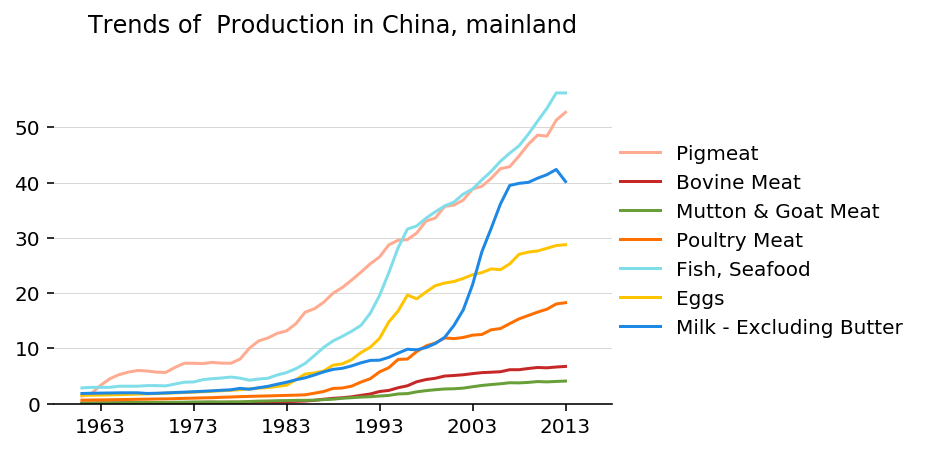

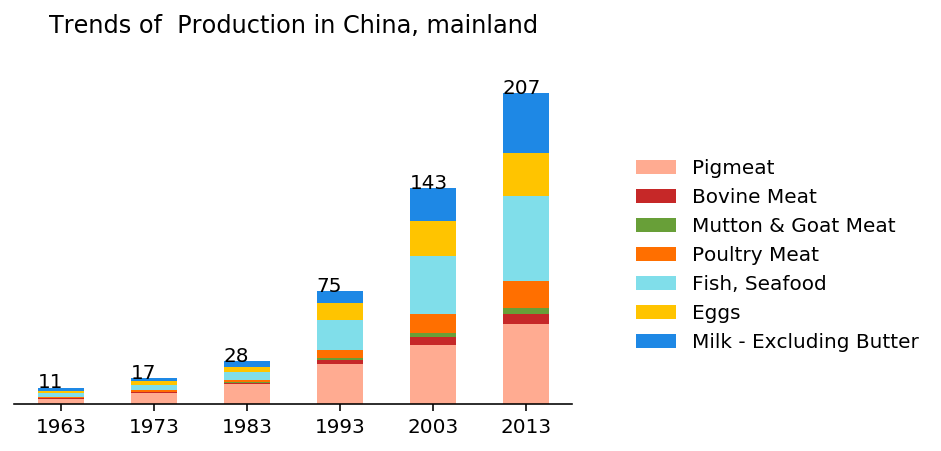

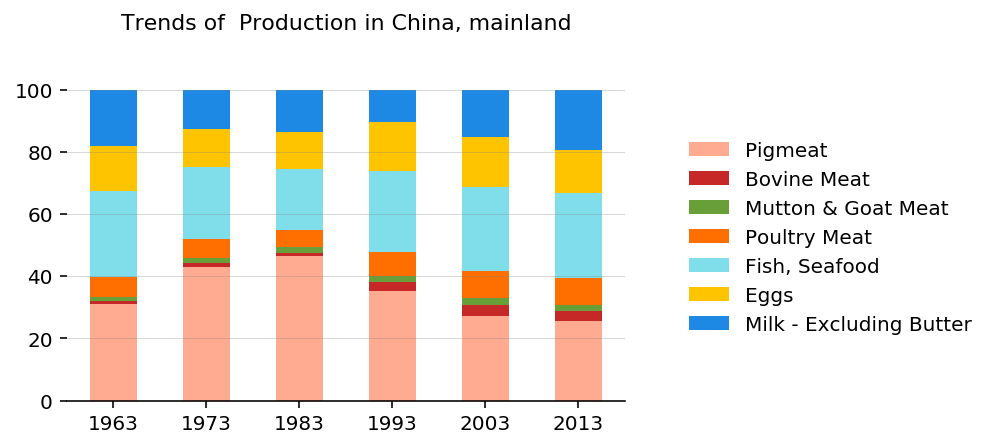

In [30]:
# 所有主要末梢类别, 加上末梢不重要但总类重要的总类
plotTrendsLine(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)
plotTrendsBar(A, E, toUnit='Million Tonnes', changeUnit = 1/1000000)

# # 设置颜色
# cmeat,cfish,cegg,cmilk,coffal,cfat=\
# 'peru','deepskyblue','yellowgreen','darkgray','firebrick','orange'
# cpig,ccattle,cgoat,cbirds,cother=\
# 'hotpink','maroon','orangered','gold','lightslategray'

# # 重要总类的分类
# plotTrends(D, A, E, items_group='Animal Products', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cmeat,cfish,cegg,cmilk,coffal,cfat],
#           )
# plotTrends(D, A, E, items_group='Meat', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cpig,ccattle,cgoat,cbirds,cother],
#           )

### 2. An Area's World Ranking of Some Items

In [31]:
def ranking_AreaItemInWorld(
    area,
    element,
    items_group='',
    items=[],
    area_list=LIST_countries,
    fig_size=FIG_size,
    colors=CLs,
):  
    
    items = getItems(element=element, items_group=items_group, items=items)
    
    # make a pivot for a particular area where 
    # year, items as columns, items' rankings in areas list as values
    rankings = {}
    for i in items:
        if i in PVs_AreaYear[element].keys():
            df = PVs_AreaYear[element][i].copy()
            ranks = np.array([])
            try: 
                df_areas = df[df.index.isin(area_list)]
                for year in df_areas.columns:
                    rank = df_areas.sort_values(year, ascending=False).index.tolist().index(area)+1
                    ranks = np.append(ranks,rank)
                rankings[i]=ranks
            except:continue           
    df_rank = pd.DataFrame(rankings)
    df_rank.index = Years
    
    # plot settings
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    title_y=1.15
    
    # === ploting ===
    title = "World Ranking of {} in {}".format(element.title(), area)
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    df_ = df_rank.loc[X_ticks]      
    display(df_)
    df_.plot.line(color=colors, linestyle=':', marker='o', linewidth=2, alpha=1, ax=plt.gca())

    ax = plt.gca()
    ax.legend(labels=rankings.keys(),fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.gca().invert_yaxis()
    
    # save
#     path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_1_' + title + '.png'
#     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#     print('Img saved as: ' + path)

,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,3.0,42.0,12.0,3.0,4.0,3.0,30.0
1973,1.0,30.0,6.0,3.0,3.0,3.0,32.0
1983,1.0,24.0,3.0,4.0,3.0,3.0,25.0
1993,1.0,5.0,1.0,2.0,1.0,1.0,16.0
2003,1.0,3.0,1.0,2.0,1.0,1.0,8.0
2013,1.0,3.0,1.0,2.0,1.0,1.0,3.0


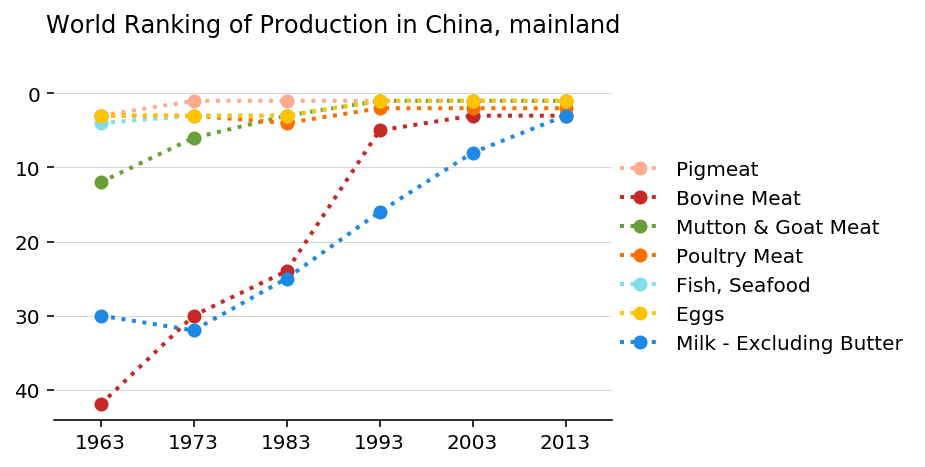

In [32]:
ranking_AreaItemInWorld(A,E)

### 3. Compare

#### World Map

In [33]:
# Map

countries = list(set(LIST_countries_OECD+LIST_countries_EU+LIST_countries_G20+LIST_countries_BRICS+USSR))+["USSR"]
print(f'OECD, EU, G20 and BRICS are considered. {len(countries)} in total.')
print(countries)

# countries = list(set(LIST_countries_OECD)) + China
# print(f'OECD and China are considered. {len(countries)} in total.')
# display(countries)

toUnit = 'Million Tonnes'
changeUnit = 1/1000000
years = [Years[-1]-50, Years[-1]-30, Years[-1]-10, Years[-1]]
fill_color_='BuGn'
items_group=''
items=[]
items = items = getItems(element=E, items_group=items_group, items=items)

df_all = {}
for i in items:
    df = PVs_AreaYear[E][i].copy()
    df = df[df.index.isin(countries)]
    df_all[i] = pd.DataFrame()
    for y in years:
        df_y = df[[y]].dropna()
        df_y = df_y * changeUnit
        df_all[i] = pd.concat([df_all[i], df_y], sort=True, axis=1)       

        title = f"{i} Production in {y} ({toUnit})"
        cn_map = folium.Map( width=1000, height=600, location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
        threshold_scale = np.around(np.linspace(
            0, 
            df_y[y].values.max()+df_y[y].values.max()/20, 
            num=6, endpoint=True
        ),3)
    
        if y < 1992: geo_data_=f'{FAO_meta}/geojson/world_countries_before1992.json'
        elif y >= 1992: geo_data_=f'{FAO_meta}/geojson/world_countries.json'
        folium.Choropleth(
            geo_data=geo_data_,
            data=df_y,
            name = y,
            columns=[df_y.index, y],
            key_on='feature.properties.name',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        
#         display(cn_map) 

#         path = f'{LOCAL_ROOT}/results/{domain}/map/02-{title}.html'
#         cn_map.save(path)
#         print('Atala saved as: ' + path)

for i in items:
    display(df_all[i].head())

OECD, EU, G20 and BRICS are considered. 64 in total.
['Denmark', 'Malta', 'Iceland', 'Japan', 'South Africa', 'Spain', 'Czechia', 'Poland', 'United Kingdom', 'China, Macao SAR', 'Luxembourg', 'Norway', 'China, Hong Kong SAR', 'Georgia', 'Russian Federation', 'Belgium', 'Indonesia', 'Uzbekistan', 'Italy', 'Azerbaijan', 'Republic of Moldova', 'Greece', 'Chile', 'France', 'Republic of Korea', 'Croatia', 'Argentina', 'Switzerland', 'Portugal', 'Kyrgyzstan', 'Australia', 'Belarus', 'China, Taiwan Province of', 'Cyprus', 'Turkey', 'Finland', 'Canada', 'Slovakia', 'United States of America', 'China, mainland', 'Hungary', 'Romania', 'India', 'Ukraine', 'Bulgaria', 'Germany', 'Estonia', 'Ireland', 'Latvia', 'Netherlands', 'Sweden', 'New Zealand', 'Austria', 'Saudi Arabia', 'Russian FederationKazakhstan', 'Tajikistan', 'Turkmenistan', 'Slovenia', 'Armenia', 'Brazil', 'Israel', 'Lithuania', 'Mexico', 'USSR']


,1963,1983,2003,2013
Argentina,0.1574,0.2072,0.1498,0.4160
Armenia,NaN,NaN,0.0115,0.0126
Australia,0.1162,0.2391,0.4189,0.3609
Austria,0.2971,0.4558,0.5059,0.5293
Azerbaijan,NaN,NaN,0.0014,0.0007


,1963,1983,2003,2013
Argentina,2.6053,2.4553,2.6580,2.8220
Armenia,NaN,NaN,0.0299,0.0536
Australia,0.9286,1.5429,2.0730,2.3178
Austria,0.1430,0.2035,0.2077,0.2289
Azerbaijan,NaN,NaN,0.0666,0.1208


,1963,1983,2003,2013
Argentina,0.1605,0.1165,0.0655,0.0662
Armenia,NaN,NaN,0.0062,0.0090
Australia,0.6032,0.5306,0.6110,0.6969
Austria,0.0030,0.0033,0.0077,0.0079
Azerbaijan,NaN,NaN,0.0392,0.0709


,1963,1983,2003,2013
Argentina,0.0620,0.3571,0.7814,1.9665
Armenia,NaN,NaN,0.0050,0.0082
Australia,0.0508,0.3129,0.7128,1.0977
Austria,0.0354,0.0750,0.1132,0.1308
Azerbaijan,NaN,NaN,0.0271,0.0944


,1963,1983,2003,2013
Argentina,0.1223,0.4165,0.9118,0.8739
Armenia,NaN,NaN,0.0016,0.0164
Australia,0.0699,0.1686,0.2539,0.2289
Austria,0.0046,0.0047,0.0026,0.0036
Azerbaijan,NaN,NaN,0.0066,0.0016


,1963,1983,2003,2013
Argentina,0.1411,0.2722,0.3030,0.5599
Armenia,NaN,NaN,0.0282,0.0339
Australia,0.1410,0.2044,0.1304,0.2409
Austria,0.0859,0.0990,0.0851,0.1073
Azerbaijan,NaN,NaN,0.0384,0.0843


,1963,1983,2003,2013
Argentina,4.3673,5.654,8.1975,11.1837
Armenia,NaN,NaN,0.5137,0.6570
Australia,6.8790,5.695,10.3280,9.5220
Austria,3.1067,3.684,3.2528,3.4246
Azerbaijan,NaN,NaN,1.1678,1.7967


#### Compare with OECD

In [34]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

In [35]:
def sumOfGroup (
    element,
    areas_list,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        
        areas = []
        for c in df.columns:
            if c in areas_list: areas.append(c)
        df = df[areas]
        df = df.fillna(np.nan)

        df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
            
        df = df['Sum']
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    df_res.index.names = ['Year']
    return df_res

In [36]:
DATA_OECD = sumOfGroup(E, areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)
DATA_world = trendsOfArea('World', E, items=items)

toUnit='Million Tonnes'
changeUnit=1/1000000
area = A

df_world = DATA_world.copy() * changeUnit
df_OECD = DATA_OECD.copy() * changeUnit
df_area = DATA_area.copy() * changeUnit

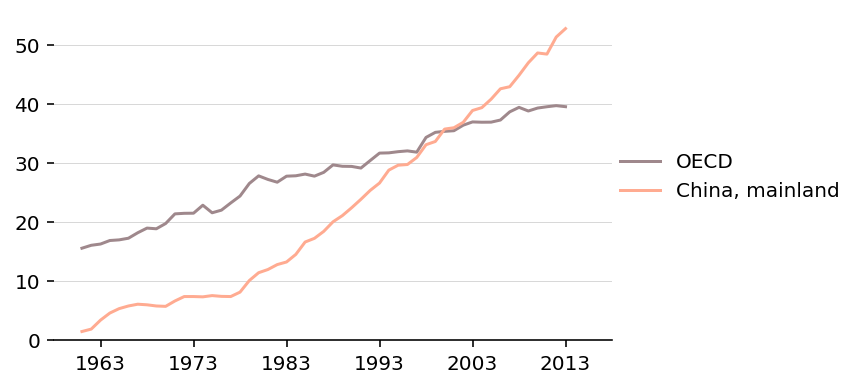

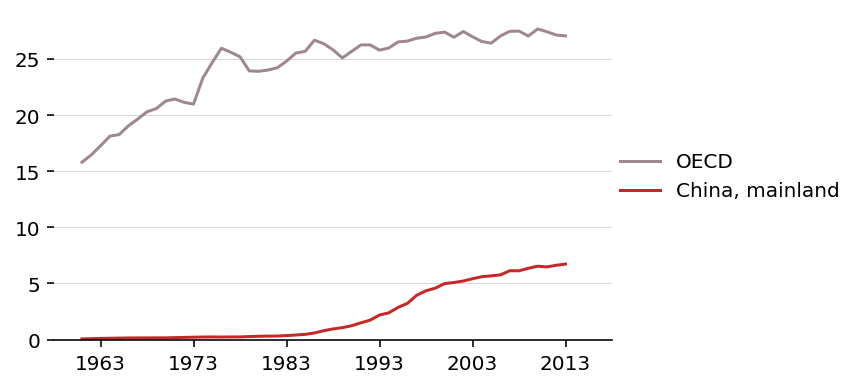

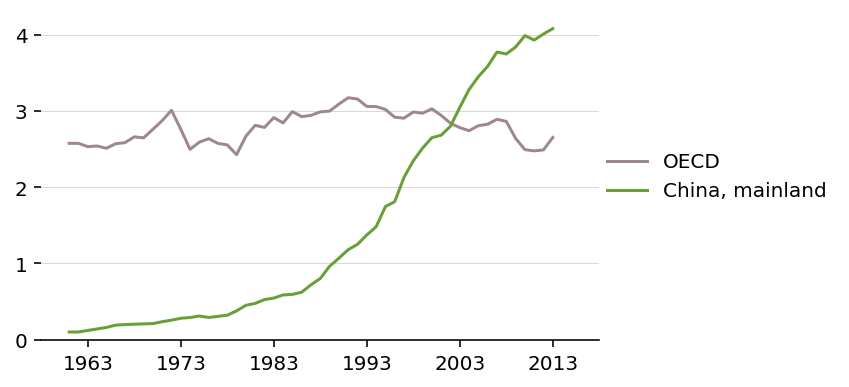

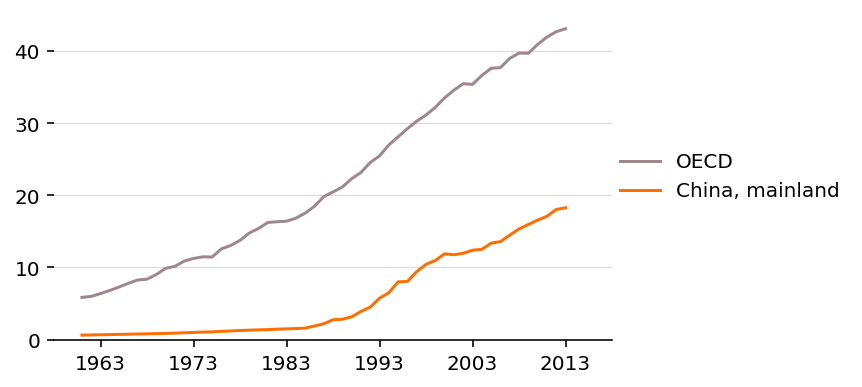

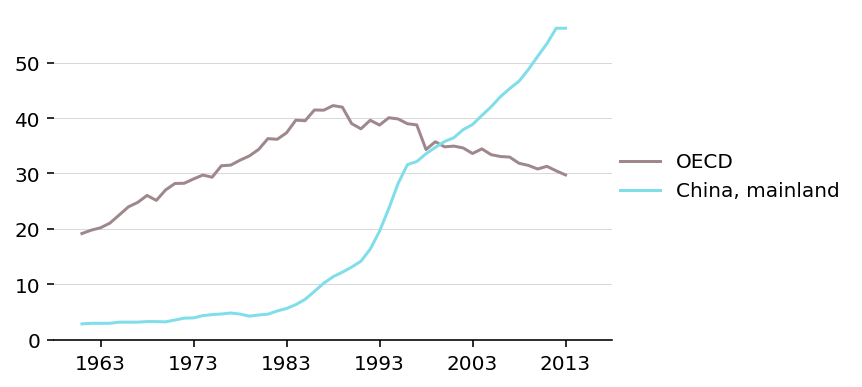

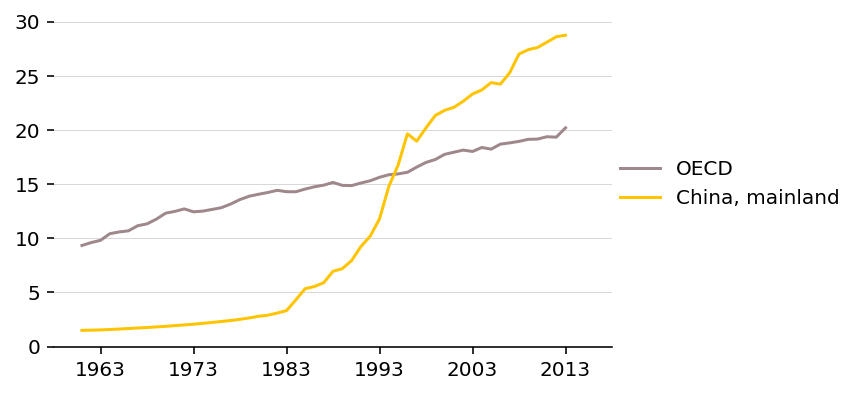

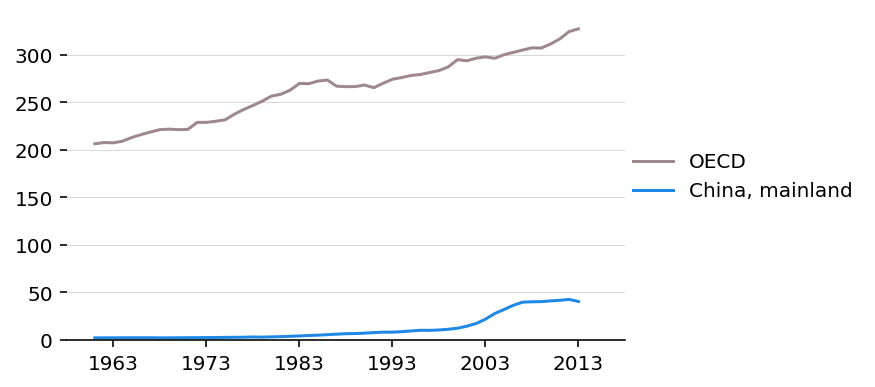

In [37]:
# ==== Line
for i, c in zip(items, CLs):
    
    title = ""
    fig = plt.figure(figsize = FIG_size,dpi=DPI)
    plt.title(title, fontsize=TIT_size)
    
    df_OECD[i].plot(color=GF_brand_gray, ax=plt.gca())
    df_area[i].plot(color=c, ax=plt.gca())
    
    ax = plt.gca()
    ax.legend(labels=['OECD', area],fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [38]:
df_world=df_world.loc[X_ticks]
df_OECD=df_OECD.loc[X_ticks]
df_area=df_area.loc[X_ticks]

print('World: ')
display(df_world.head())
print('OECD: ')
display(df_OECD.head())
print(f'{A}: ')
display(df_area.head())

World: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,27.9345,31.8755,6.0548,9.6838,43.3607,15.6170,342.0282
1973,40.3376,40.1407,6.6299,17.5004,61.1230,21.8709,409.5506
1983,55.3185,48.8105,7.7174,28.9153,76.0608,29.1286,494.3857
1993,73.4550,54.4603,9.8017,47.7374,102.9605,40.8823,523.9418
2003,91.9694,59.6908,11.5421,74.8956,124.3195,58.3588,610.1896


OECD: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,16.2029,17.2631,2.5318,6.3827,20.1936,9.8152,207.4391
1973,21.4316,20.9841,2.7601,11.2486,29.0129,12.4496,229.0041
1983,27.7085,24.8100,2.9138,16.4145,37.3399,14.3056,270.0727
1993,31.6208,25.7910,3.0603,25.4548,38.7415,15.6362,274.4334
2003,36.9078,26.9843,2.7820,35.3691,33.6051,18.0206,298.0592


China, mainland: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
1963,3.3000,0.107,0.1200,0.6725,2.9424,1.540,1.8990
1973,7.3000,0.214,0.2800,0.9900,3.9196,2.070,2.1482
1983,13.1610,0.357,0.5450,1.4850,5.6166,3.323,3.8660
1993,26.5459,2.189,1.3730,5.7360,19.5589,11.798,7.8574
2003,38.8467,5.425,3.0463,12.3880,38.8327,23.331,21.5016


In [39]:
def areaInWorld(
    df_area_,
    df_total_,
):

    fig_size = (8,4)

    fig = plt.figure(figsize = fig_size, dpi=DPI)
    fig.tight_layout()                          
    plt.subplots_adjust(hspace =0.1)
    
    title = ""

    ax2 = fig.add_subplot(211)
    plt.title(title, fontsize=TIT_size)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=ax2)
    df_area_.plot.bar(color=CLs, width=0.8, ax=ax2)

    ax2.legend_.remove()
    ax2.xaxis.label.set_visible(False)
    ax2.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax2.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    plt.xticks([])
    ax2.set_ylim(175, 800)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1 = fig.add_subplot(212)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=ax1)
    df_area_.plot.bar(color=CLs, width=0.8, ax=ax1)

    ax1.legend_.remove()
    ax1.xaxis.label.set_visible(False)
    ax1.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax1.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax1.set_ylim(0, 175)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['right'].set_visible(False)

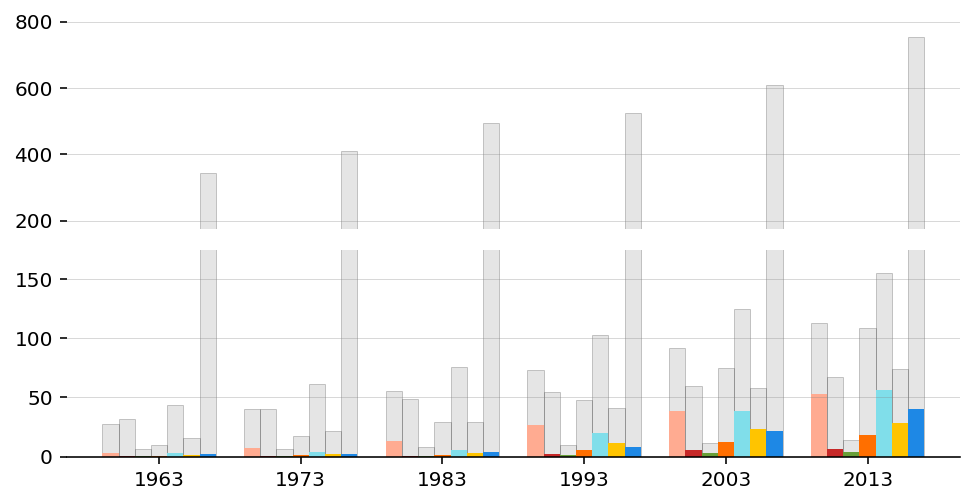

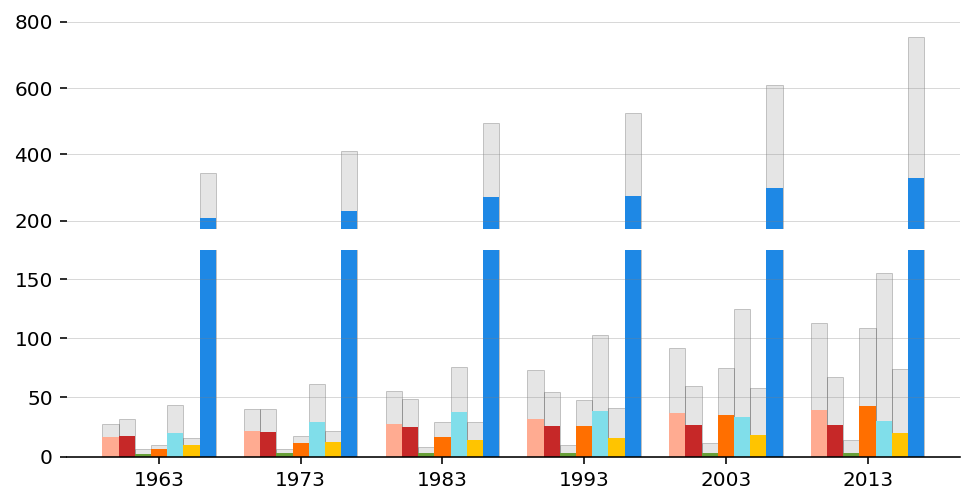

In [40]:
areaInWorld(df_area_=df_area.copy(), df_total_=df_world)
areaInWorld(df_area_=df_OECD.copy(), df_total_=df_world)

In [41]:
percent_world = pd.DataFrame()
percent_OECD = pd.DataFrame()
percent_area = pd.DataFrame()

percent_world['Year'] = X_ticks
percent_OECD['Year'] = X_ticks
percent_area['Year'] = X_ticks

percent_world.set_index('Year', inplace=True)
percent_OECD.set_index('Year', inplace=True)
percent_area.set_index('Year', inplace=True)

for i in items:
    percent_world[i] = np.array(df_world[i]/df_world[i])*100
    percent_OECD[i] = np.array(df_OECD[i]/df_world[i])*100
    percent_area[i] = np.array(df_area[i]/df_world[i])*100

print('World: ')
display(percent_world.head())
print('OECD: ')
display(percent_OECD.head())
print(f'{A}: ')
display(percent_area.head())

World: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1973,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1983,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1993,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2003,100.0,100.0,100.0,100.0,100.0,100.0,100.0


OECD: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,58.0032,54.1579,41.8148,65.9112,46.5712,62.8495,60.6497
1973,53.1306,52.2764,41.6304,64.2766,47.4665,56.9231,55.9160
1983,50.0890,50.8292,37.7567,56.7674,49.0921,49.1118,54.6279
1993,43.0479,47.3575,31.2216,53.3227,37.6275,38.2469,52.3786
2003,40.1306,45.2069,24.1029,47.2245,27.0312,30.8789,48.8470


China, mainland: 


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter
Year,,,,,,,
1963,11.8133,0.3357,1.9819,6.9446,6.7859,9.8611,0.5552
1973,18.0973,0.5331,4.2233,5.6570,6.4126,9.4646,0.5245
1983,23.7913,0.7314,7.0620,5.1357,7.3844,11.4080,0.7820
1993,36.1390,4.0194,14.0077,12.0157,18.9966,28.8585,1.4997
2003,42.2387,9.0885,26.3929,16.5404,31.2362,39.9785,3.5238


In [42]:
def areaInWorldPercent(
    df_area_,
    df_total_,
):

    fig_size = (8,4)

    title = ""
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size)

    df_total_.plot.bar(color='gray', width=0.8, edgecolor='black', linewidth=0.5, alpha=0.2, ax=plt.gca())
    df_area_.plot.bar(color=CLs, width=0.8, ax=plt.gca())

    ax=plt.gca()
    ax.legend_.remove()
    ax.xaxis.label.set_visible(False)
    ax.set_xticklabels(X_ticks, rotation=0, ha='center')
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

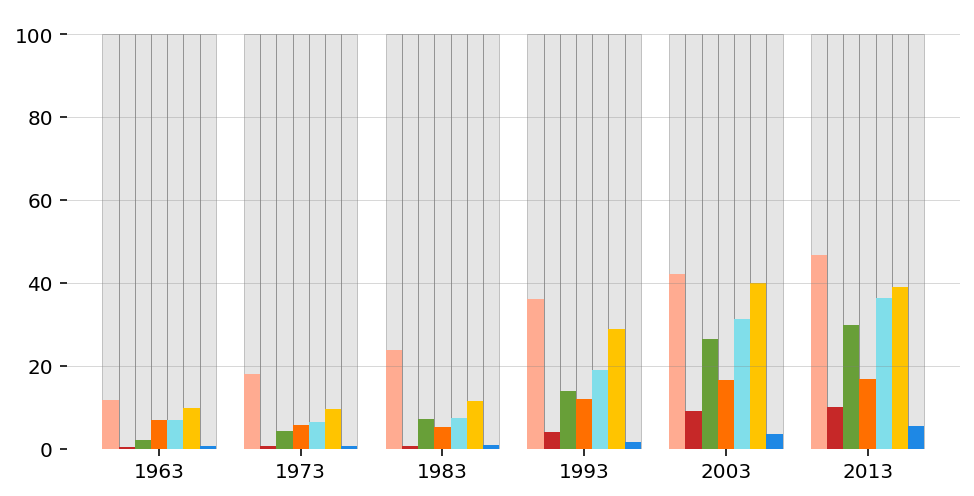

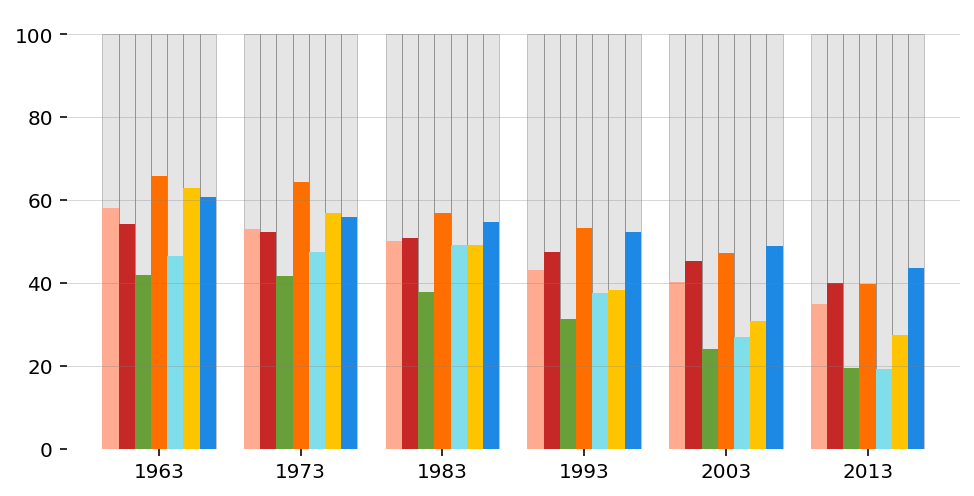

In [43]:
areaInWorldPercent(df_area_=percent_area.copy(), df_total_=percent_world)
areaInWorldPercent(df_area_=percent_OECD.copy(), df_total_=percent_world)

In [44]:
def plotPieCompare(
    df_area_,
    df_total_,
    element=E,
    area_=A,
    total_='World',
    years=[1963, 2013],
    fig_size = (12,6),
):
    
    title = "Proportions of Different {} in {} and the Proportions {} takes".format(element, total_, area_)

    # plot all items in the world...

    fig = plt.figure(figsize = fig_size,dpi=300)
    fig.tight_layout()                          
    plt.subplots_adjust(wspace =0.3, hspace =0.2)
    plt.suptitle(title, fontsize=TIT_size)

    df_compare = {}
    fig_no=0
    for y in years:
        fig_no+=1

        df_compare[y] = pd.concat([df_area_.loc[y].transpose(), df_total_.loc[y].transpose()], axis=1)
        df_compare[y].columns = [area_, total_]
        df_compare[y]['Others'] = df_compare[y][total_]-df_compare[y][area_]
        print(y, area_)
        display(df_compare[y])

        df = df_compare[y].copy()

        ax = fig.add_subplot(1,2, fig_no)
        plt.title(y, fontsize=TIT_size)

        size = 0.5
        outer_radius = 2
        inner_colors = [GF_brand_gray, Gray1]

        outer_explode = np.zeros(len(items))
        inner_explode = np.zeros(len(items*2))

# #         Explode Items
#         for n in range(len(items)):
#             if items[n] in ITEMs_main:
#                 outer_explode[n] = 0.15
#                 inner_explode[2*n] = 0.15

        area_pct = ['{}{}'.format(int(df.loc[i][area_]/df.loc[i][total_]*100),'%') for i in df.index.values]
        inner_labels = []
        for i in area_pct:
            inner_labels.append(i)
            inner_labels.append('')

        shadow = False
        startangle = 0
        plt.pie(df[total_].values, 
                autopct='%1.0f%%',
                pctdistance=1.1,
#                 explode=list(outer_explode),
                radius=outer_radius, 
                colors=CLs,
                center = (0,0),
                textprops = {'fontsize':LEG_size}, 
                wedgeprops=dict(width=size),
                shadow=shadow,
                startangle=startangle,
                )
        plt.pie(df[[area_,'Others']].values.flatten(), 
                labels=inner_labels,
                labeldistance = 0.85,
#                 explode=list(inner_explode),
                radius=outer_radius-size, 
                colors=inner_colors,
                center = (0,0),
                textprops = {'fontsize':LEG_size}, 
                wedgeprops=dict(width=size),
                shadow=shadow,
                startangle=startangle,
               )
        plt.axis('equal')          # equal 使得为正圆

    ax=plt.gca()
    ax.legend(labels=list(df.index.values)+[area_,'Other'],frameon=False,fontsize=LEG_size, 
              loc='lower center',bbox_to_anchor=(-0.1,-0.1),borderaxespad = 0.)

    #     path = './results/FAO_LivestockFish_FoodSupplyQuantity/img/Fig_5_'  + title[:title.find('\/')] + '.png'
    #     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
    #     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
    #     print('Img saved as: ' + path)

1963 China, mainland


,"China, mainland",World,Others
Pigmeat,3.3000,27.9345,24.6345
Bovine Meat,0.1070,31.8755,31.7685
Mutton & Goat Meat,0.1200,6.0548,5.9348
Poultry Meat,0.6725,9.6838,9.0113
"Fish, Seafood",2.9424,43.3607,40.4183
Eggs,1.5400,15.6170,14.0770
Milk - Excluding Butter,1.8990,342.0282,340.1292


2013 China, mainland


,"China, mainland",World,Others
Pigmeat,52.7330,113.0679,60.3349
Bovine Meat,6.7300,67.5404,60.8104
Mutton & Goat Meat,4.0810,13.6400,9.5590
Poultry Meat,18.2649,108.5168,90.2519
"Fish, Seafood",56.2285,154.8482,98.6197
Eggs,28.7600,73.7854,45.0254
Milk - Excluding Butter,40.1932,753.0360,712.8428


1963 OECD


,OECD,World,Others
Pigmeat,16.2029,27.9345,11.7316
Bovine Meat,17.2631,31.8755,14.6124
Mutton & Goat Meat,2.5318,6.0548,3.5230
Poultry Meat,6.3827,9.6838,3.3011
"Fish, Seafood",20.1936,43.3607,23.1671
Eggs,9.8152,15.6170,5.8018
Milk - Excluding Butter,207.4391,342.0282,134.5891


2013 OECD


,OECD,World,Others
Pigmeat,39.4897,113.0679,73.5782
Bovine Meat,27.0577,67.5404,40.4827
Mutton & Goat Meat,2.6519,13.6400,10.9882
Poultry Meat,43.0765,108.5168,65.4403
"Fish, Seafood",29.7353,154.8482,125.1129
Eggs,20.2016,73.7854,53.5838
Milk - Excluding Butter,327.5582,753.0360,425.4778


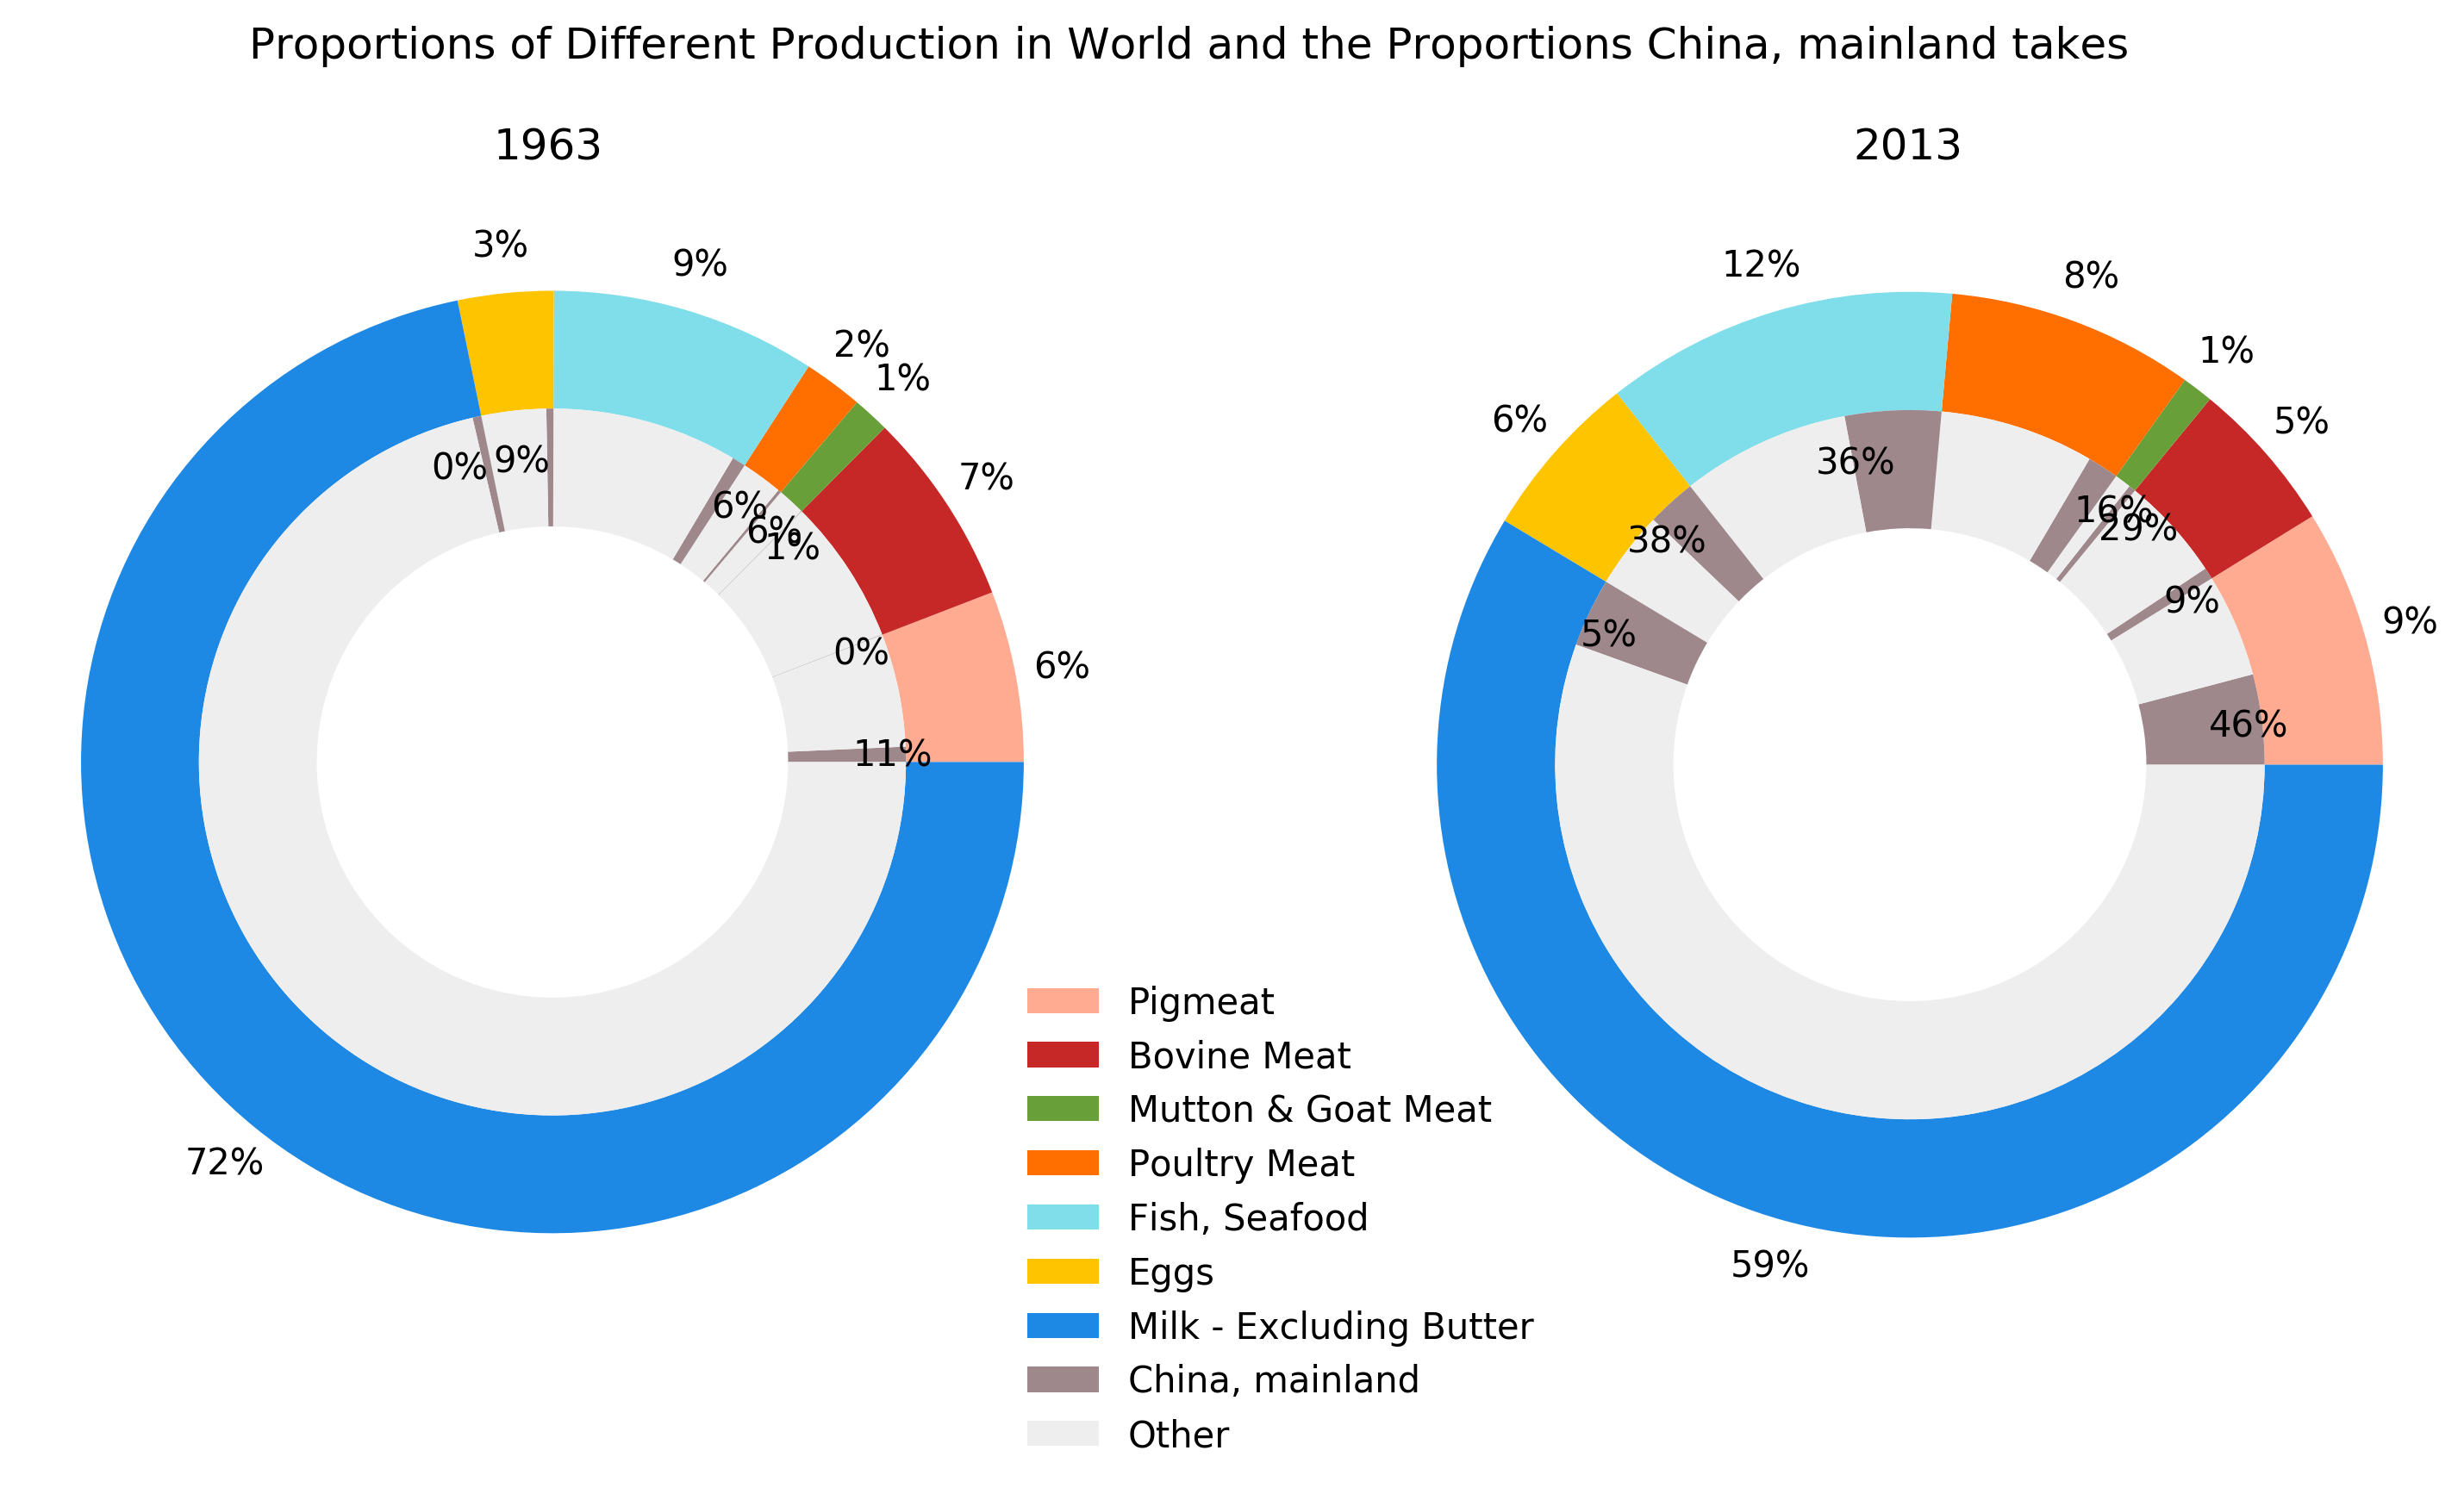

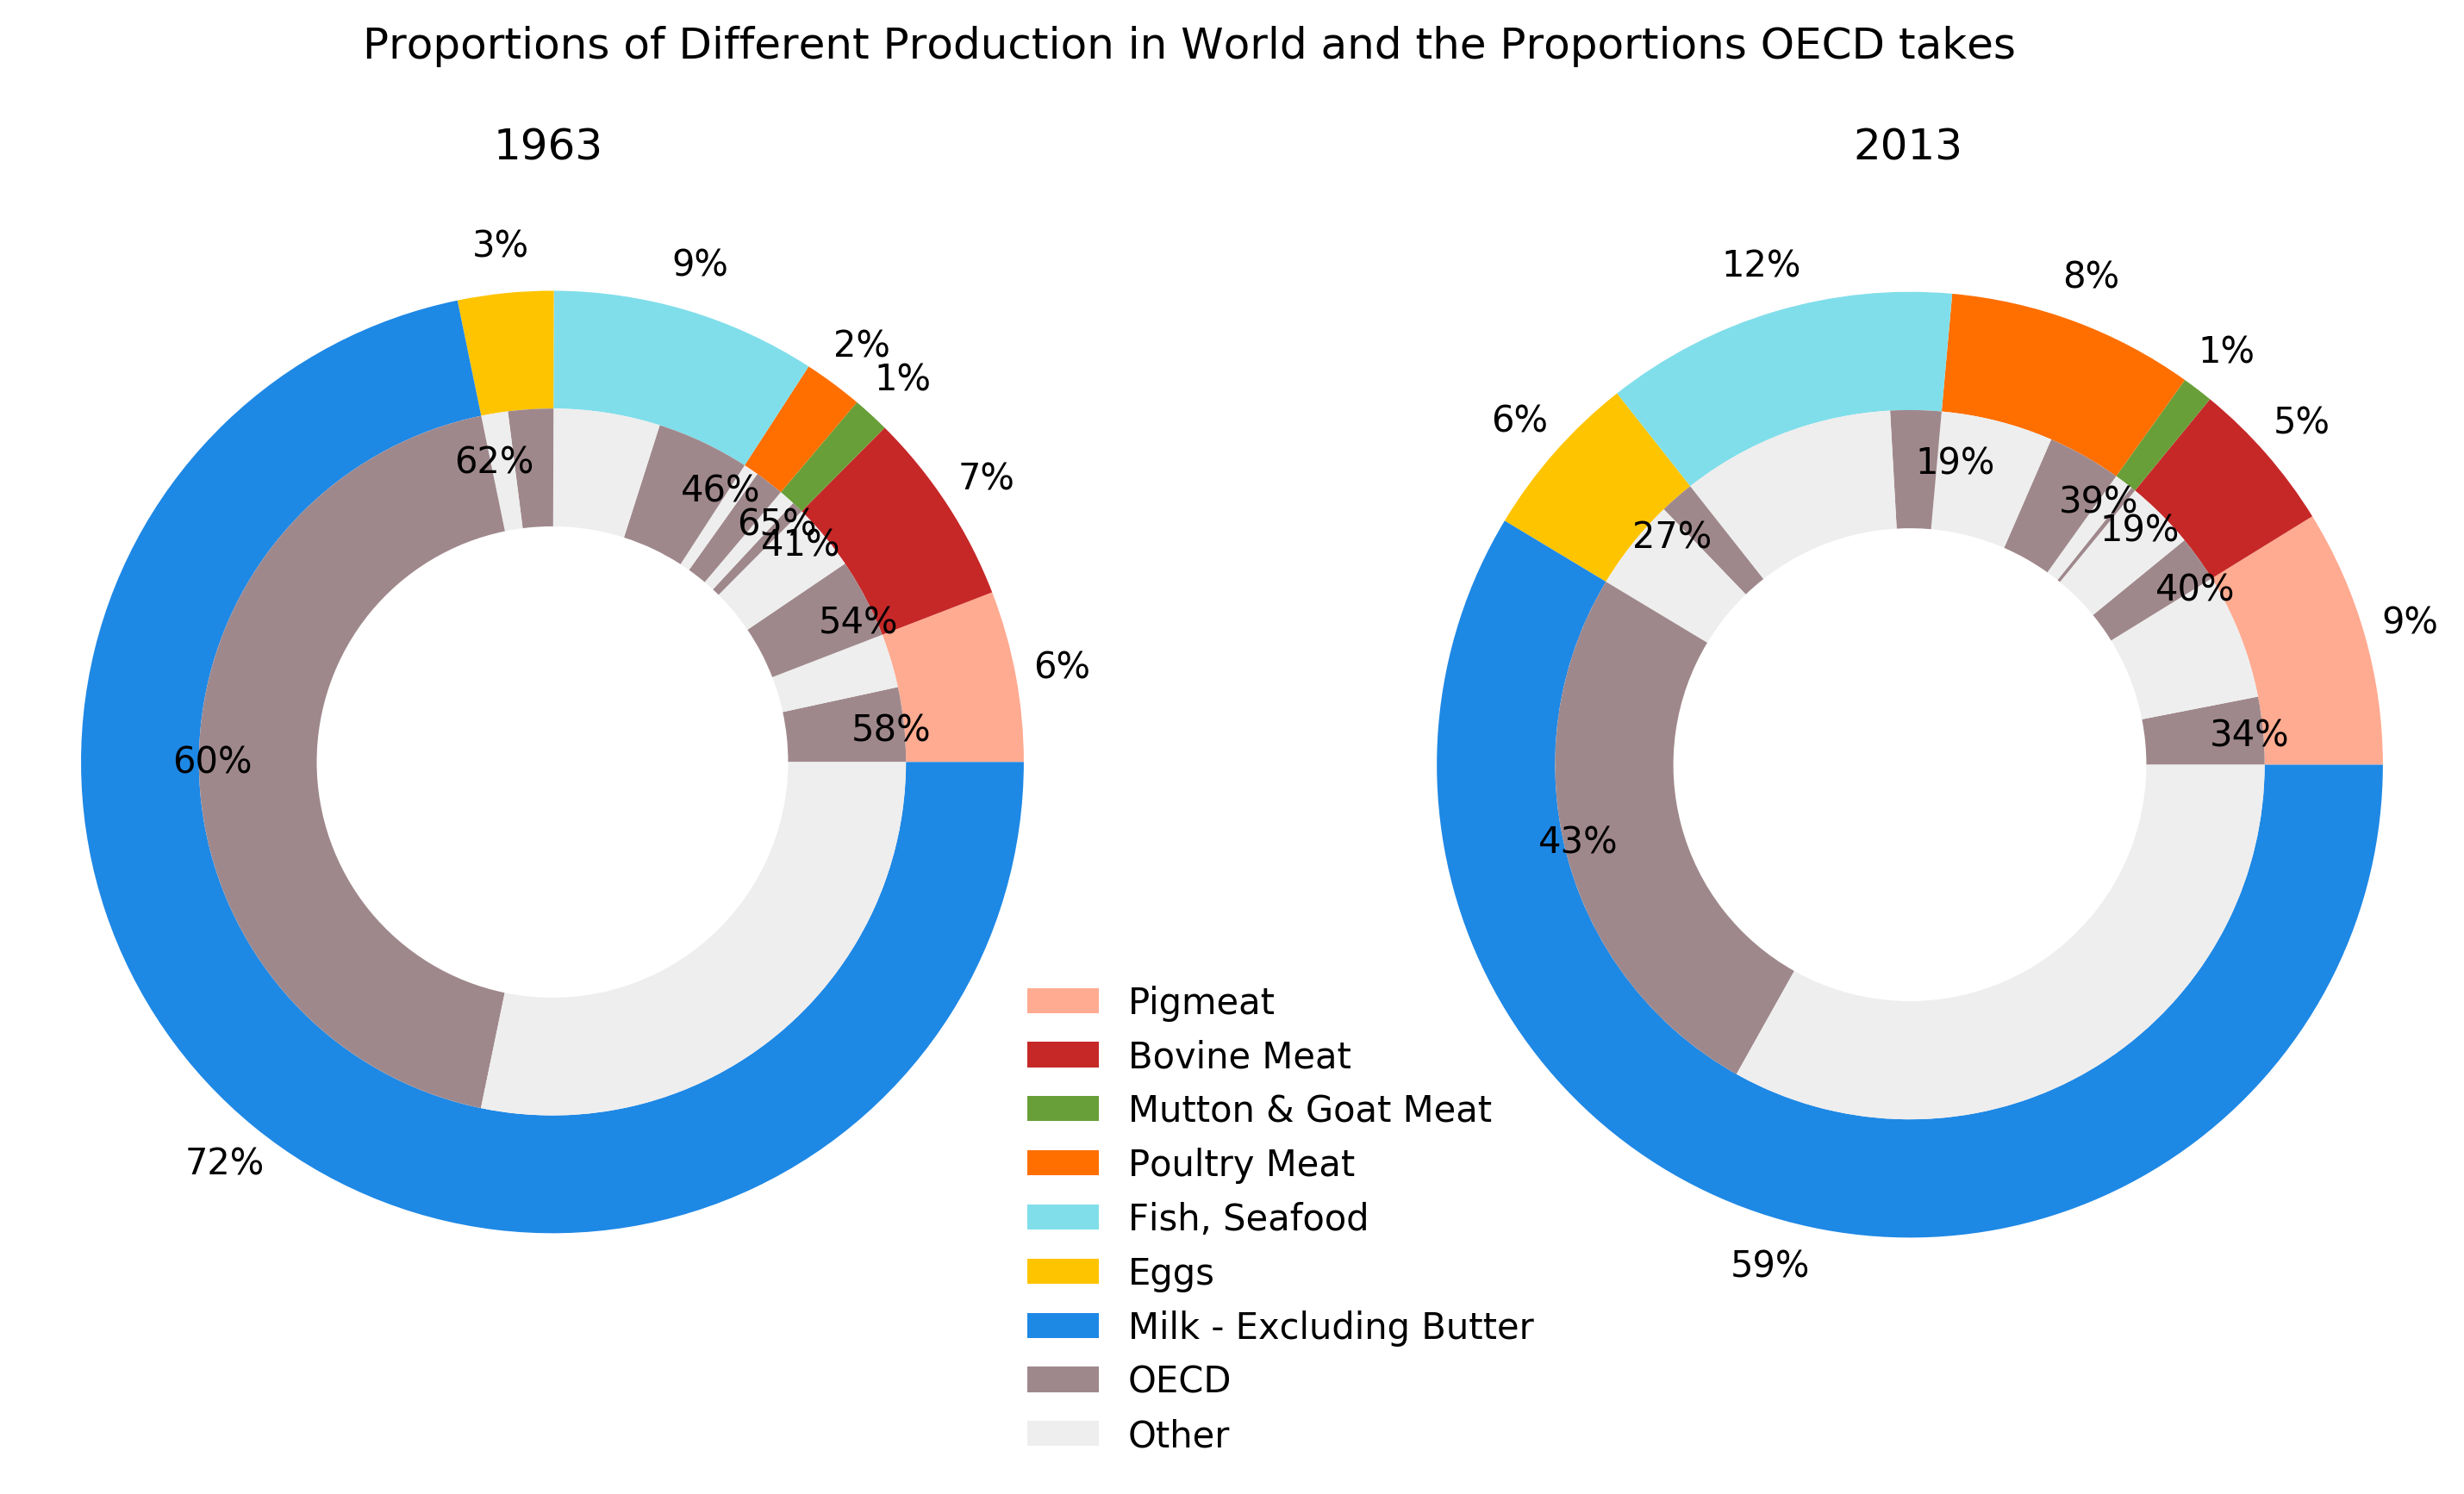

In [45]:
# China
# 设置主要贡献方面
# ITEMs_main = ['Pigmeat', 'Fish, Seafood', 'Eggs']

plotPieCompare(
    df_area_=df_area.copy(),
    df_total_=df_world.copy(),
    element=E,
    area_=A,
    total_='World',
    years=[1963, 2013],
    fig_size = (12,6),
)

# OECD
# 设置主要贡献方面
# ITEMs_main = ['Milk - Excluding Butter', 'Bovine Meat', 'Poultry Meat']

plotPieCompare(
    df_area_=df_OECD.copy(),
    df_total_=df_world.copy(),
    element=E,
    area_='OECD',
    total_='World',
    years=[1963, 2013],
    fig_size = (12,6),
)

#### Compare with Top 5

In [203]:
def compareToTopAreas(
    area,
    element,
    items_group='',
    items=[],
    toUnit='',
    changeUnit=1,
): 
    items = getItems(element=element, items_group=items_group, items=items)

    dfs = PVs_AreaYear[element]
    
    years = X_ticks
    
    if toUnit=='': Y_label = element
    else: 
        if '(' in element: Y_label = element[:element.find('(')] + '({})'.format(toUnit)
        else: Y_label = element + ' ({})'.format(toUnit)
    title = '{}: China, mainland Vs. Top 5 in the World'.format(element)

    # === Bar Plot ===
    for i, c in zip(items, CLs):
        fig_size=(8,4)
        fig=plt.figure(figsize=fig_size, dpi=DPI)
        
        df = dfs[i][dfs[i].index.isin(LIST_countries)].copy()
        df = df * changeUnit
        df = df.dropna()
        
        df_area = df[df.index==area][years]
        df_top = df.sort_values([years[-1]],ascending=False)[years].head()
        
        display(df_top)
                    
        if area in df_top.index:
            df_top.plot.bar(color=c, width=0.8, edgecolor='black', linewidth=0.5, ax=plt.gca(), )
#             n=1
#             for y in df_top.columns:
#                 width=0.2
#                 plt.bar(x=n+n*width, height=df_top[y], color=c, width=width, alpha=0+n*0.15)
#                 n+=1
                    
            ax=plt.gca()
            
            for p in ax.patches[0:5]:
                p.set_hatch(hatch='..')
            for p in ax.patches[5:10]:
                p.set_hatch(hatch='//')
            for p in ax.patches[10:15]:
                p.set_hatch(hatch='---')
            for p in ax.patches[15:20]:
                p.set_hatch(hatch='xx')
            for p in ax.patches[20:25]:
                p.set_hatch(hatch='O')
            for p in ax.patches[25:30]:
                p.set_hatch(hatch='+++')
            
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
        else: 

            df_top.plot.bar(ax=plt.gca())

            ax=plt.gca()
            ax.legend(fontsize=LEG_size,frameon=False,
                     loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
            ax.set_ylim(0,)
            ax.spines['bottom'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

        
#     path = './results/FAO_LivestockFish_CommodityBalance/img/Fig_3_'+title+'.png'
#     bbox = matplotlib.transforms.Bbox([[-1, -1], list(map(lambda x:x+2, list(fig_size)))])
#     fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
#     print('Img saved as: ' + path)

,1963,1973,1983,1993,2003,2013
Area,,,,,,
"China, mainland",3.3000,7.3000,13.1610,26.5459,38.8467,52.7330
United States of America,5.6370,5.7837,6.8955,7.7510,9.0560,10.5245
Germany,2.7226,3.6221,4.4085,3.6458,4.2393,5.5068
Spain,0.3110,0.5885,1.3420,2.0888,3.1895,3.4312
Brazil,0.5749,0.7006,0.8850,1.5000,3.0590,3.2800


,1963,1973,1983,1993,2003,2013
Area,,,,,,
United States of America,7.8857,9.8130,10.7460,10.5840,12.0390,11.7194
Brazil,1.3609,2.2020,3.2500,4.8069,7.2300,9.6750
"China, mainland",0.1070,0.2140,0.3570,2.1890,5.4250,6.7300
Argentina,2.6053,2.1486,2.4553,2.8080,2.6580,2.8220
India,1.0887,1.3762,1.8937,2.1826,2.2581,2.5766


,1963,1973,1983,1993,2003,2013
Area,,,,,,
"China, mainland",0.1200,0.2800,0.5450,1.3730,3.0463,4.0810
India,0.3828,0.3812,0.5186,0.6362,0.7017,0.7466
Australia,0.6032,0.7138,0.5306,0.6549,0.6110,0.6969
New Zealand,0.4637,0.5576,0.6809,0.4881,0.5478,0.4819
Nigeria,0.0147,0.0345,0.1093,0.1812,0.3766,0.4719


,1963,1973,1983,1993,2003,2013
Area,,,,,,
United States of America,3.3656,4.8278,7.0993,12.4396,17.2758,20.0852
"China, mainland",0.6725,0.9900,1.4850,5.7360,12.3880,18.2649
Brazil,0.1660,0.5240,1.6129,3.2351,7.9674,12.9152
Mexico,0.1550,0.2713,0.5202,1.0710,2.1612,2.8462
India,0.0794,0.0971,0.1615,0.6084,1.2490,2.3579


,1963,1973,1983,1993,2003,2013
Area,,,,,,
"China, mainland",2.9424,3.9196,5.6166,19.5589,38.8327,56.2285
Indonesia,0.9323,1.2567,2.1557,3.6578,5.4814,8.3679
Peru,6.8215,2.2956,1.5704,9.0096,6.0976,8.3391
India,1.0458,1.9580,2.5067,4.4794,6.0055,7.9786
United States of America,2.6556,2.8348,4.4068,5.9057,5.4657,5.6591


,1963,1973,1983,1993,2003,2013
Area,,,,,,
"China, mainland",1.5400,2.0700,3.3230,11.7980,23.3310,28.7600
United States of America,3.7604,3.9095,4.0217,4.2680,5.1802,5.7771
India,0.1870,0.4000,0.7040,1.3290,2.2440,3.8352
Japan,1.0300,1.8150,2.0856,2.5977,2.5304,2.5220
Mexico,0.1770,0.4059,0.7153,1.2336,1.8725,2.5161


,1963,1973,1983,1993,2003,2013
Area,,,,,,
India,19.9410,23.2000,38.8020,58.8600,86.6600,135.6000
United States of America,56.7906,52.3856,63.3160,68.3270,77.2894,91.2769
"China, mainland",1.8990,2.1482,3.8660,7.8574,21.5016,40.1932
Pakistan,6.3171,7.8990,9.6620,17.1200,27.8110,39.0170
Brazil,5.6247,7.8455,11.9264,16.2182,23.0787,32.6530


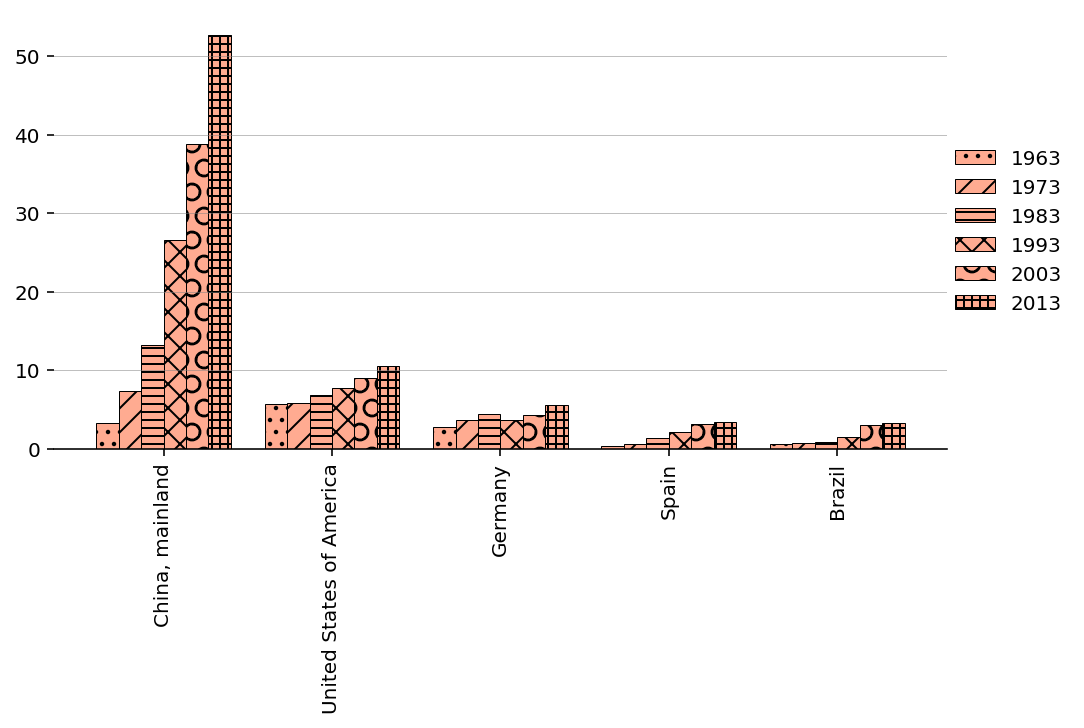

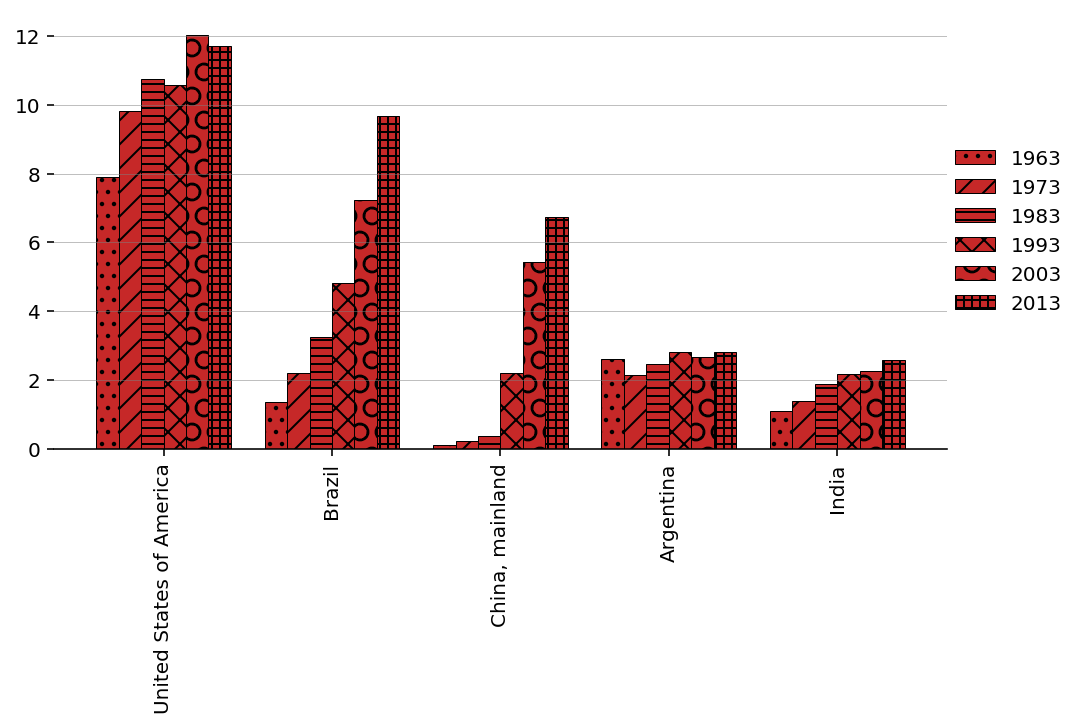

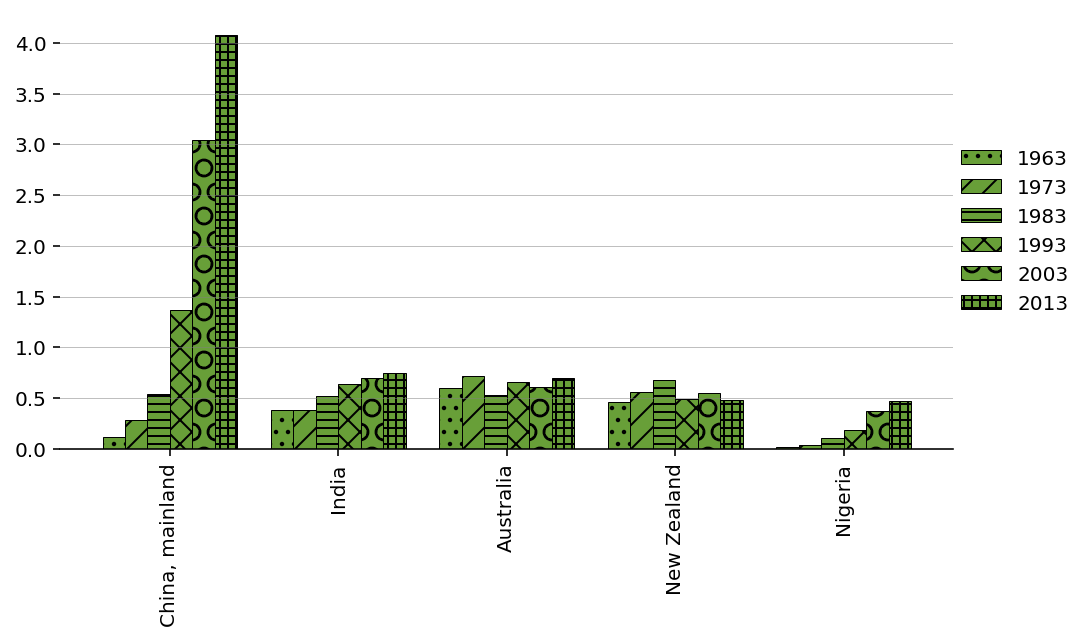

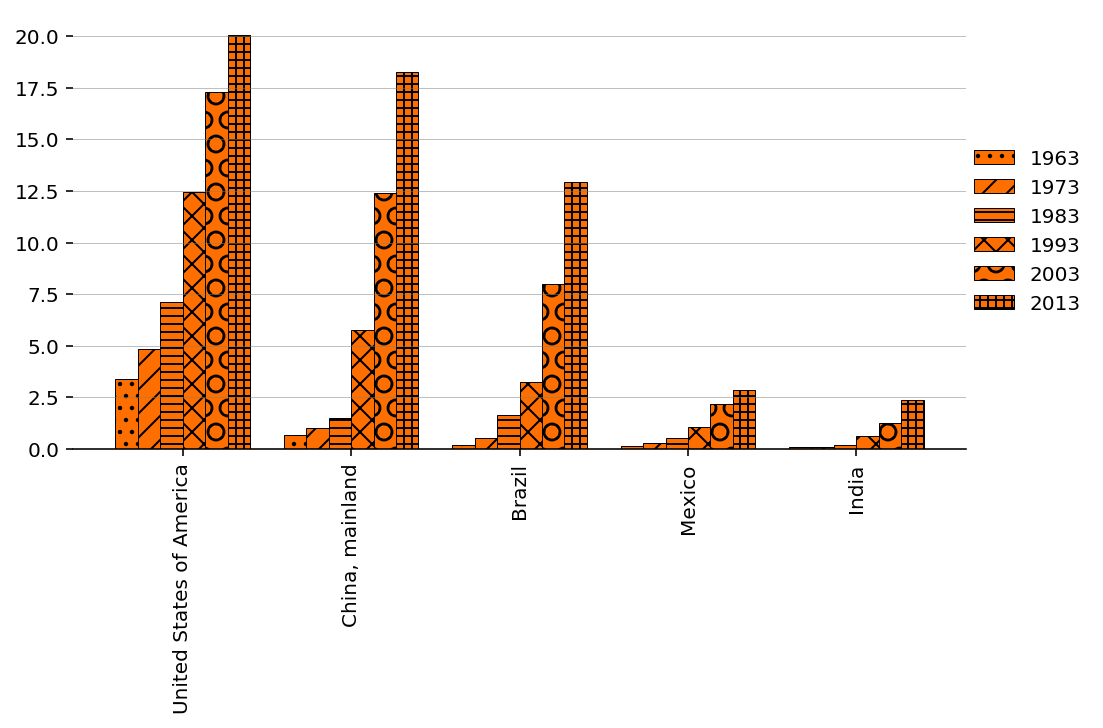

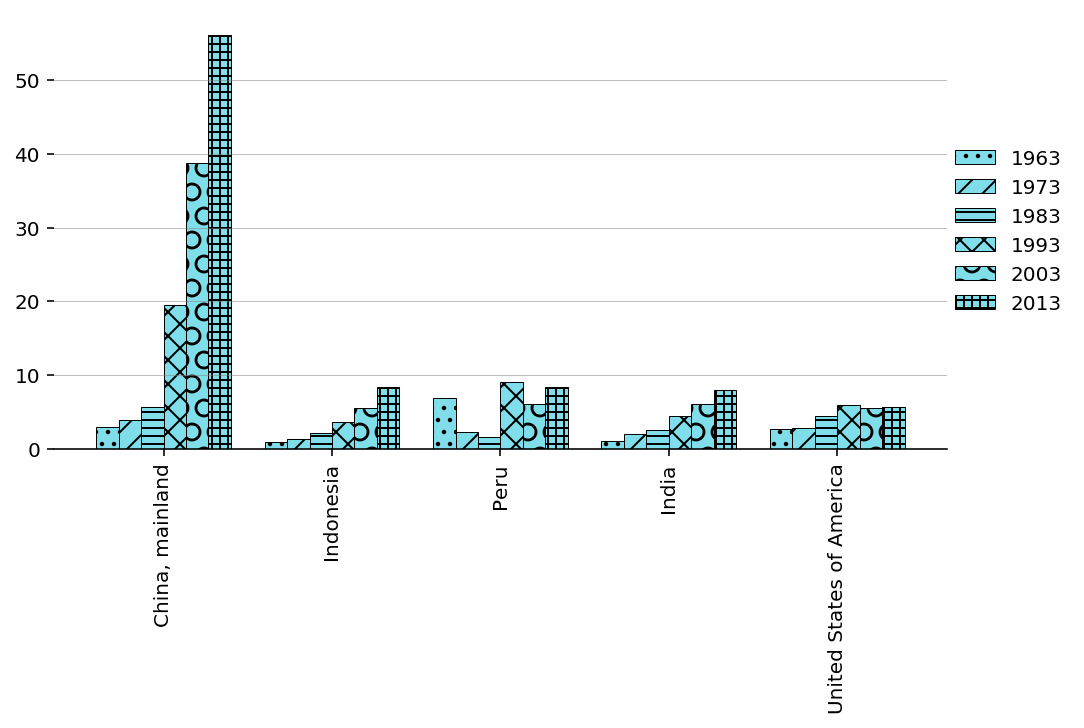

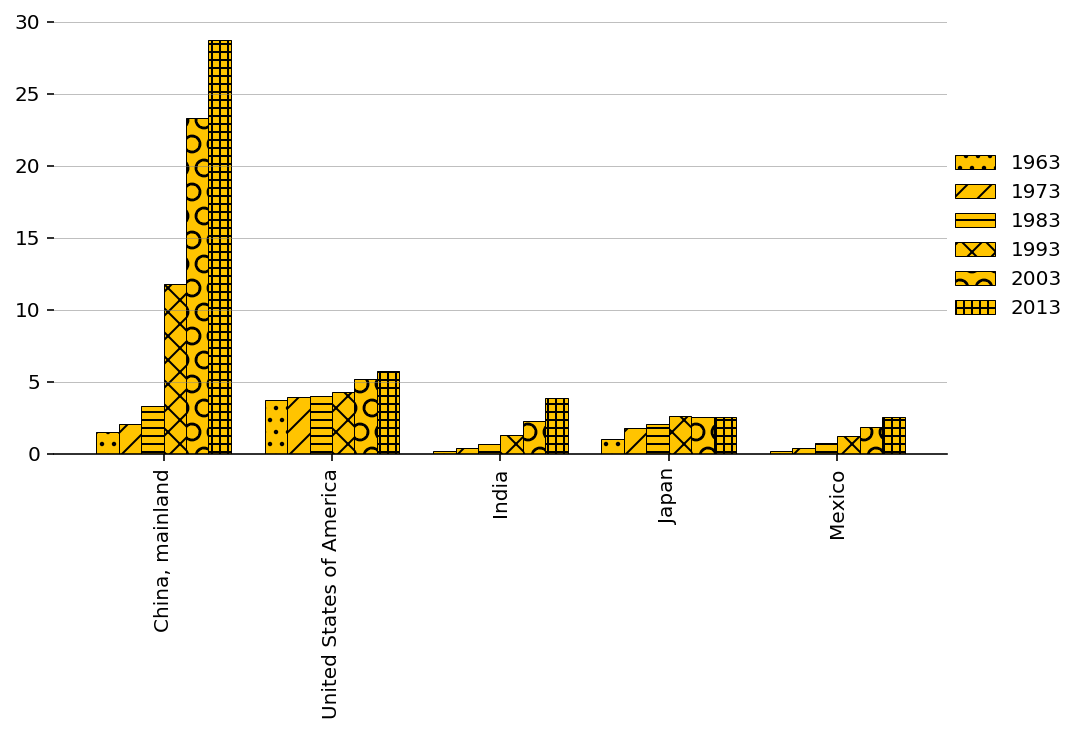

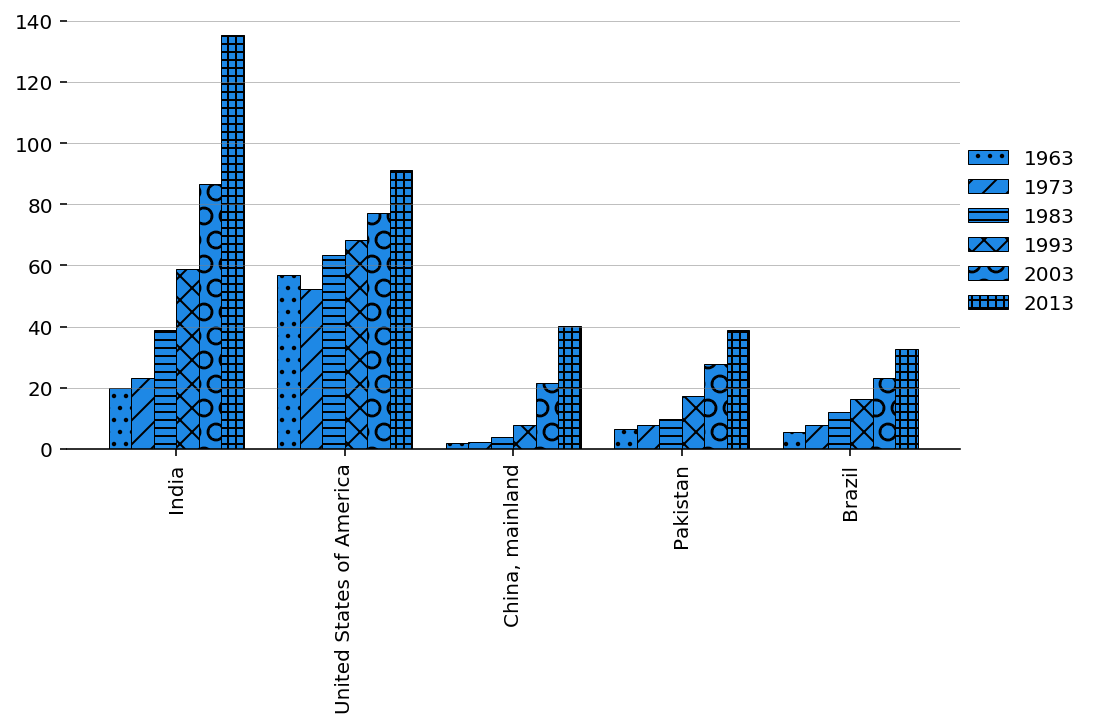

In [204]:
items=ITEMs.copy()

compareToTopAreas(A, E, items=items, toUnit='Million Tonnes', changeUnit=1/1000000)

### Other Regions Trends

World


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,27.9345,31.8755,6.0548,9.6838,43.3607,15.6170,342.0282,476.5545
1973,40.3376,40.1407,6.6299,17.5004,61.1230,21.8709,409.5506,597.1531
1983,55.3185,48.8105,7.7174,28.9153,76.0608,29.1286,494.3857,740.3368
1993,73.4550,54.4603,9.8017,47.7374,102.9605,40.8823,523.9418,853.2388
2003,91.9694,59.6908,11.5421,74.8956,124.3195,58.3588,610.1896,1030.9658


Northern America


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,6.1743,8.5887,0.3636,3.6453,3.8469,4.0453,65.1632,91.8272
1973,6.5471,10.7193,0.2421,5.2910,3.9672,4.2276,60.0543,91.0486
1983,7.9253,11.7785,0.1790,7.6326,5.7588,4.3599,70.7348,108.3688
1993,8.9454,11.4437,0.1637,13.2126,7.0910,4.5886,75.8284,121.2735
2003,10.9384,13.2423,0.1078,18.3874,6.7348,5.5735,85.0249,140.0092


Western Europe


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,5.0262,3.6676,0.1457,0.9910,1.9680,1.8794,62.7892,76.4670
1973,7.1341,3.9034,0.1737,1.7427,2.0749,2.5685,72.5379,90.1353
1983,8.7864,4.7630,0.2544,2.4021,1.9929,3.0129,87.9412,109.1530
1993,9.2259,4.6378,0.2305,3.3866,1.7955,2.6973,75.9194,97.8931
2003,9.6048,3.8538,0.2153,4.1591,1.8370,2.6043,75.8938,98.1682


Australia & New Zealand


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.1589,1.2217,1.0670,0.0582,0.1195,0.1864,12.2255,15.0373
1973,0.2715,1.8834,1.2714,0.1822,0.1916,0.2528,13.2378,17.2907
1983,0.2788,2.0550,1.2115,0.3466,0.3736,0.2605,12.6109,17.1370
1993,0.3773,2.3978,1.1430,0.5394,0.7316,0.2114,16.5570,21.9575
2003,0.4661,2.7333,1.1588,0.8589,0.8889,0.1789,24.6770,30.9619


South-Eastern Asia


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.8642,0.6100,0.0449,0.3784,3.2192,0.5609,0.4173,6.0948
1973,1.1730,0.8271,0.0603,0.7248,6.0022,0.8022,0.5479,10.1374
1983,1.7444,0.9422,0.1147,1.4572,8.4516,1.3569,1.0516,15.1187
1993,3.3337,1.2654,0.1518,3.0636,12.4361,2.0911,1.4889,23.8305
2003,5.1215,1.2663,0.2017,4.9262,18.2773,3.0298,2.6620,35.4848


Japan


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.2794,0.1859,0.0024,0.1780,6.2221,1.0300,2.7630,10.6609
1973,0.9705,0.2458,0.0005,0.6847,10.0705,1.8150,4.9084,18.6953
1983,1.4288,0.4949,0.0002,1.2391,11.1609,2.0856,7.0423,23.4519
1993,1.4396,0.5943,0.0005,1.3180,7.9878,2.5977,8.6257,22.5636
2003,1.2737,0.4960,0.0002,1.2398,5.4710,2.5304,8.4001,19.4111


Republic of Korea


,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk - Excluding Butter,Sum
1963,0.0579,0.0310,0.0009,0.0171,0.4733,0.0519,0.0088,0.6408
1973,0.0901,0.0475,0.0007,0.0537,1.4510,0.1511,0.1067,1.9009
1983,0.3686,0.0944,0.0016,0.1222,2.3784,0.3022,0.7168,3.9844
1993,0.7700,0.2040,0.0026,0.3740,2.6197,0.4526,1.8634,6.2862
2003,1.1490,0.1880,0.0029,0.4290,2.0295,0.5630,2.3710,6.7323


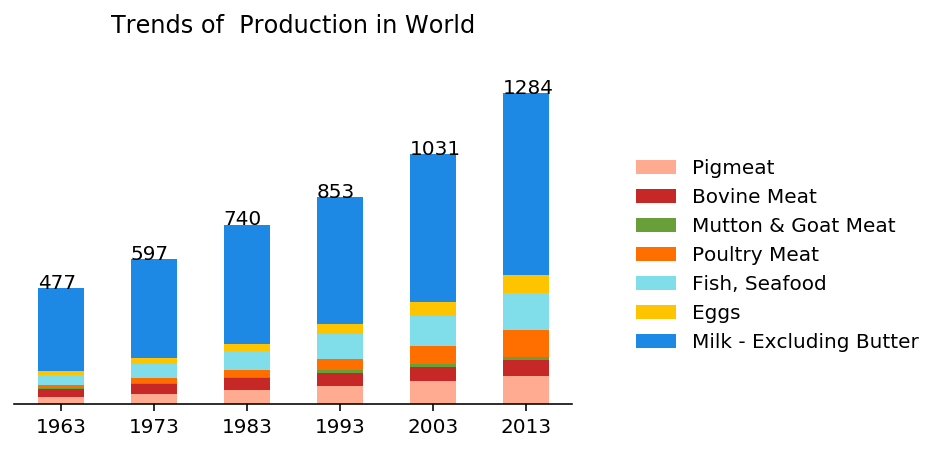

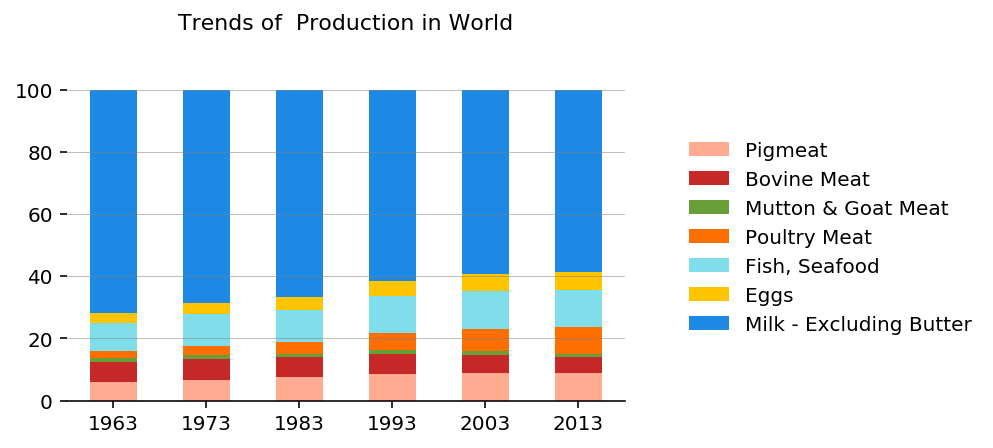

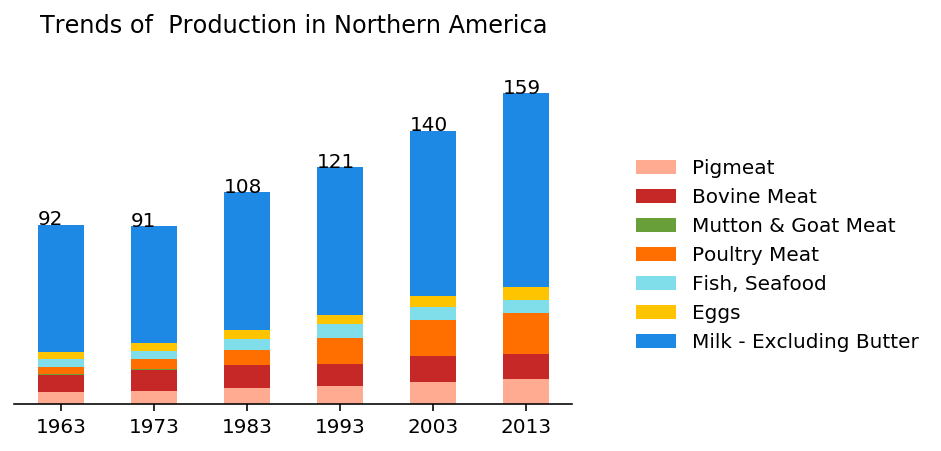

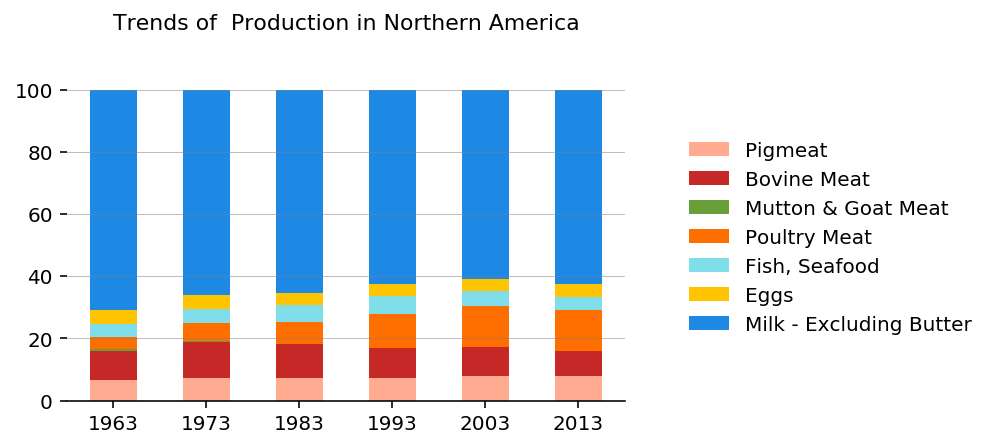

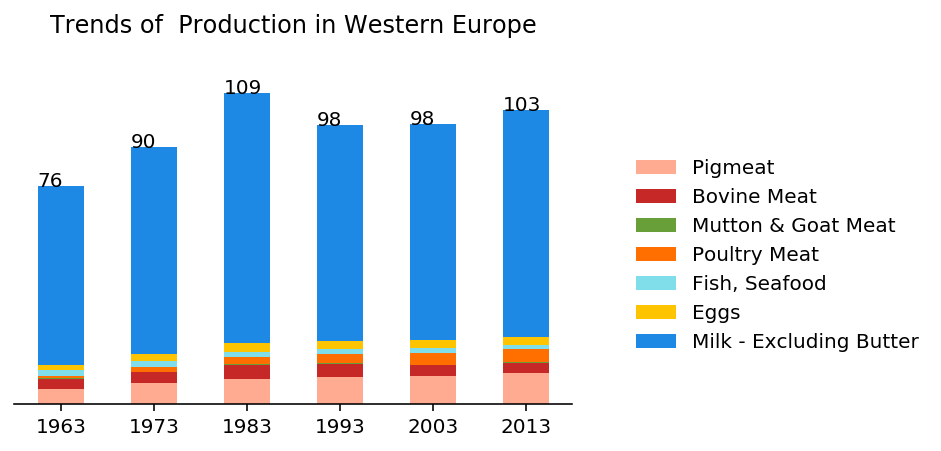

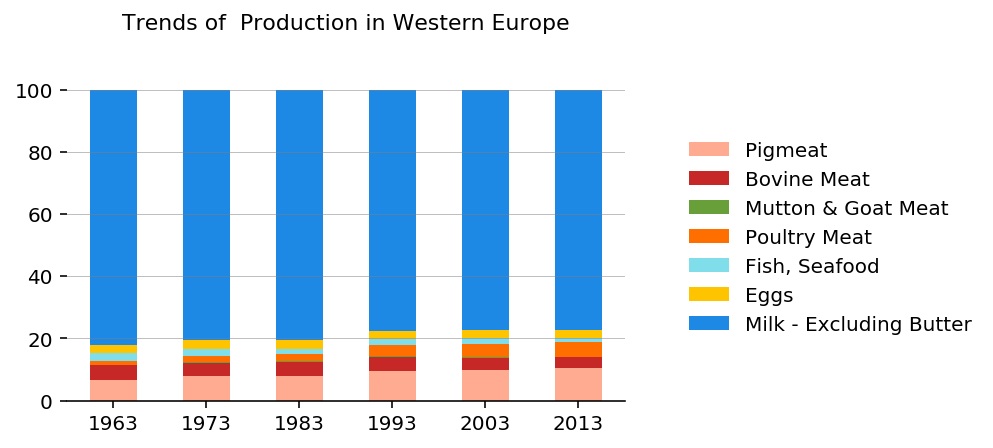

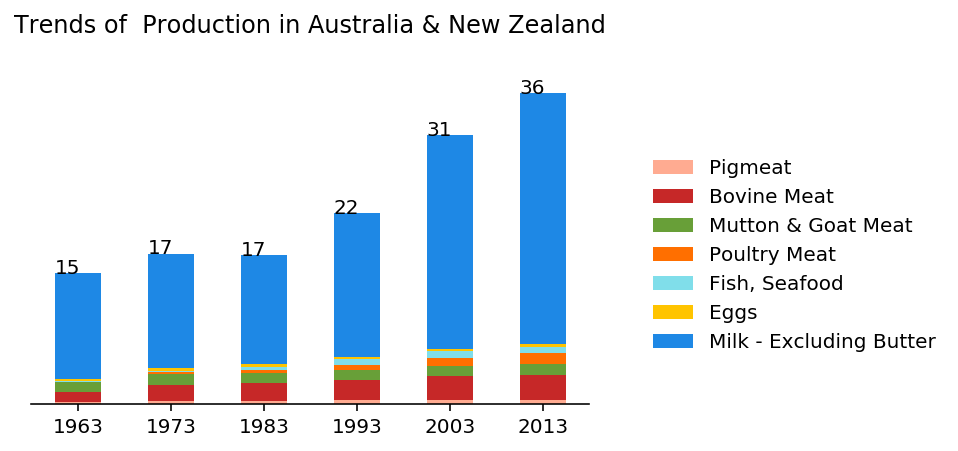

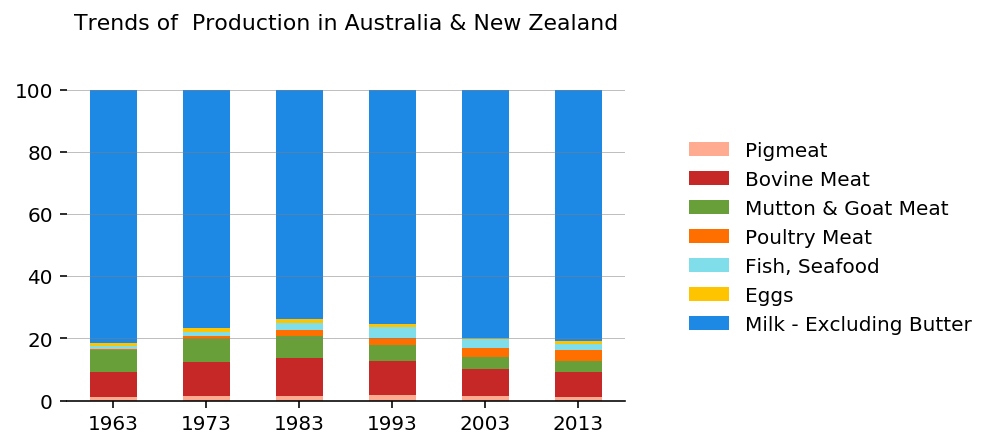

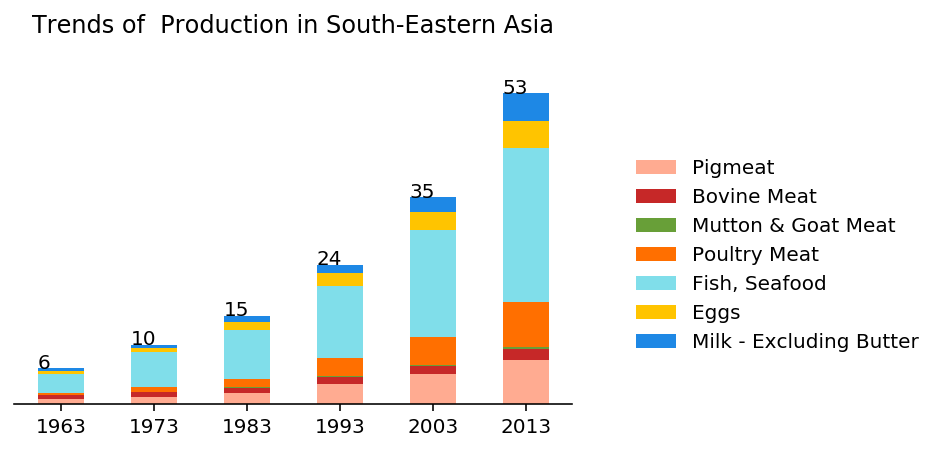

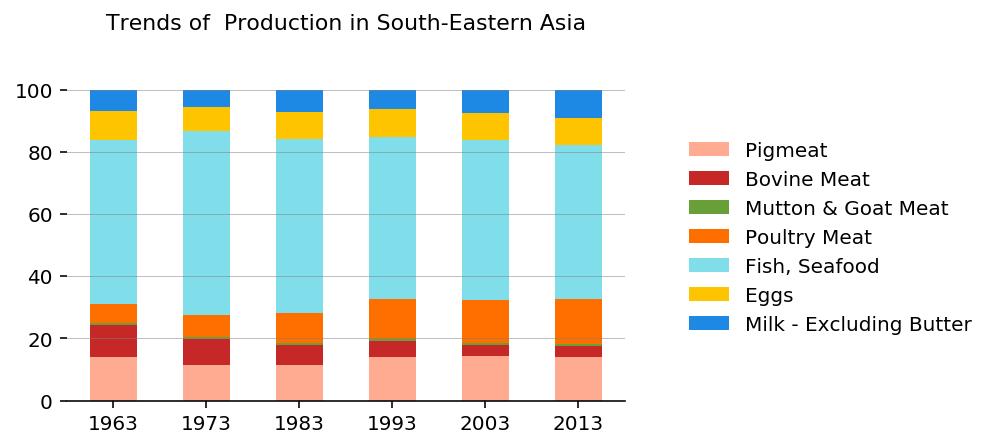

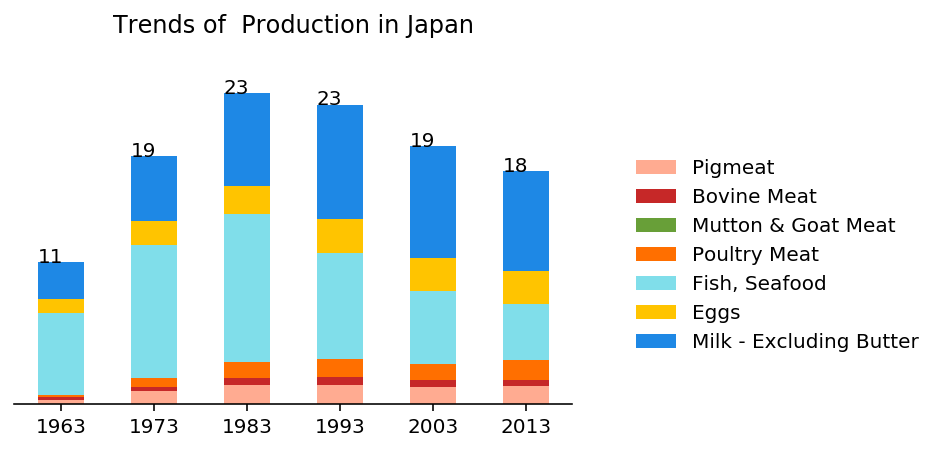

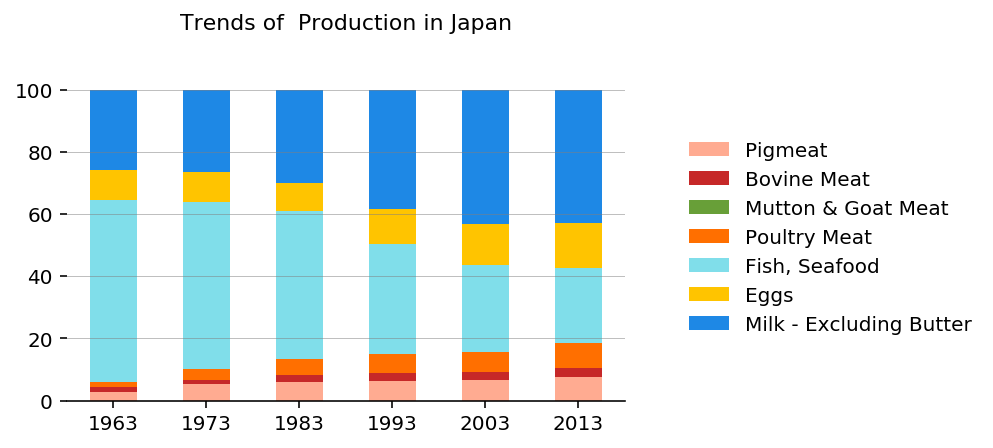

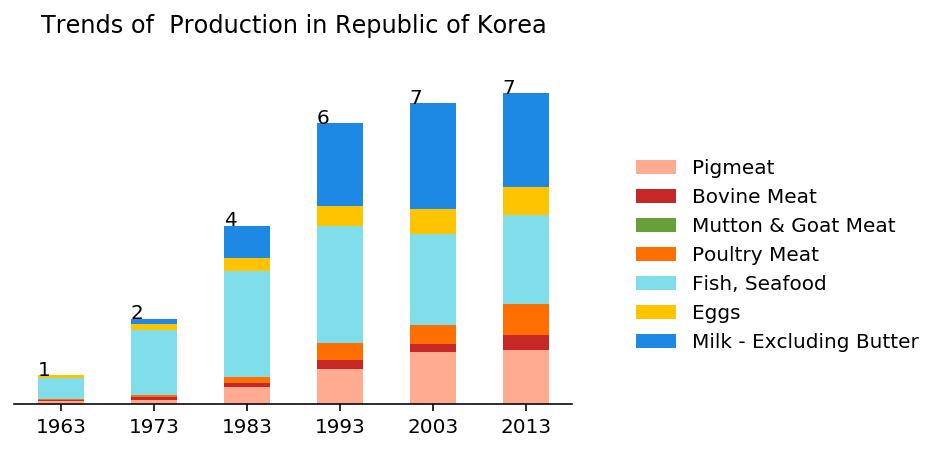

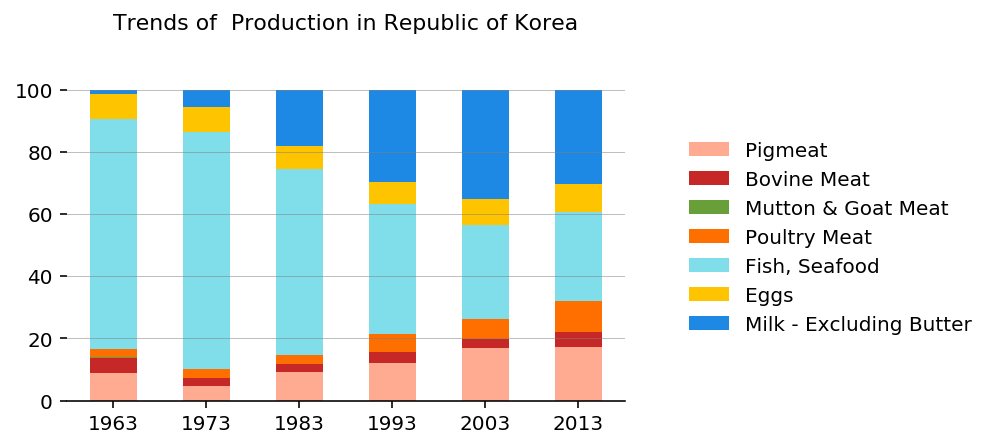

In [205]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsBar(a, E, toUnit='Million Tonnes', changeUnit = 1/1000000)